In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.RAW

num_decomps = 1
num_subsets = 2
num_mixtures = 2

# Number of input mixtures for dense generator
num_input_mixtures = 2

balanced = False

#node_type = "single"
#node_type = "block"
node_type = "layer"

log_weights = True
log_inference = True

num_classes = 10

# Input parameters
num_rows = 28
num_cols = 28
num_vars = num_rows * num_cols
num_vals = 2

#device_name = '/gpu:0'

### Learning

In [3]:
learning_rate = 0.001
log = True

optimizer = tf.train.AdamOptimizer

learning_type = spn.LearningType.DISCRIMINATIVE
#learning_type = spn.LearningType.GENERATIVE

#learning_inference_type = spn.LearningInferenceType.HARD
learning_inference_type = spn.LearningInferenceType.SOFT

# Weight initialization
weight_init_value = spn.ValueType.RANDOM_UNIFORM(10, 11)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL
#value_inference_type = spn.InferenceType.MPE

num_epochs = 10

last_batch = True

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("mnist")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


[WARNING] [tensorflow:warning] From <ipython-input-4-91d82e6c3195>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


[WARNING] [tensorflow:warning] From /home/zkytony/py3/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use tf.data to implement this functionality.


[WARNING] [tensorflow:warning] From /home/zkytony/py3/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.


[WARNING] [tensorflow:warning] From /home/zkytony/py3/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


[WARNING] [tensorflow:warning] From /home/zkytony/py3/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
def show_mnist(img):
    img=np.reshape(img, (num_rows, num_cols))
    plt.imshow(img, interpolation='none')
    plt.show()

### Process data

In [6]:
def process_set(data):
    threshold = 20
    images = np.reshape(data, (-1, num_rows, num_cols))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 1.0, interp='nearest').ravel() > threshold).astype(dtype=int))
    images=np.vstack(resized)
    return images

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/zkytony/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


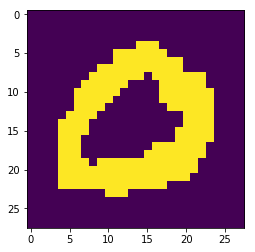

In [8]:
#show_mnist(train_images[19])

In [9]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 784)


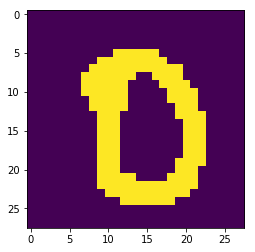

(6179, 784)


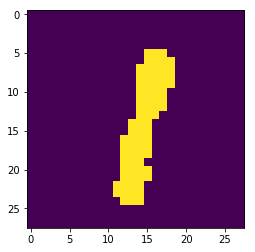

(980, 784)


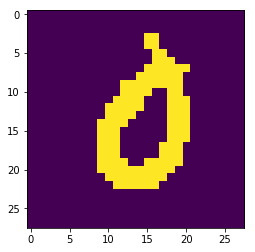

(1135, 784)


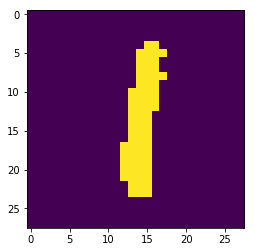

In [10]:
# print(train_images_0.shape)
# show_mnist(train_images_0[334])
# print(train_images_1.shape)
# show_mnist(train_images_1[22])
# print(test_images_0.shape)
# show_mnist(test_images_0[334])
# print(test_images_1.shape)
# show_mnist(test_images_1[22])

# Generate SPN structure

In [11]:
#with tf.device(device_name):
ivs = spn.IVs(num_vars=num_rows*num_cols, num_vals=num_vals)

dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps, num_subsets=num_subsets,
                                            num_mixtures=num_mixtures, num_input_mixtures=num_input_mixtures,
                                            input_dist=input_dist, balanced=balanced,
                                            node_type=(spn.DenseSPNGeneratorLayerNodes.NodeType.SINGLE if 
                                                       node_type=="single" else 
                                                       spn.DenseSPNGeneratorLayerNodes.NodeType.BLOCK))

sub_spns = []
for i in range(num_classes):
    sub_spns.append(dense_gen.generate(ivs, root_name=("Sub-SPN_%d" % i)))
root = spn.Sum(*sub_spns, name="root")

if node_type == "layer":
    # Convert SPN nodes to LayerNodes
    root = dense_gen.convert_to_layer_nodes(root)

# Generate SPN weights
spn.generate_weights(root, init_value=weight_init_value, log=log_weights)

# Generate Latent IVs for the root
latent = root.generate_ivs(name="root_IVs")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/zkytony/Documents/thesis/experiments/libspn/libspn/utils/math.py:466: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Add Learning Ops

In [12]:
value_inference_type

<InferenceType.MARGINAL: 0>

In [13]:
# with tf.device(device_name):
learning = spn.GDLearning(root, log=log_inference,
                          value_inference_type = value_inference_type,
                          learning_rate=learning_rate,
                          learning_type=learning_type,
                          learning_inference_type=learning_inference_type)
reset_accumulators = learning.reset_accumulators()
learn_spn = learning.learn(optimizer=optimizer)

train_likelihood = learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)
init_weights = spn.initialize_weights(root)
init_weights = [init_weights, tf.global_variables_initializer()]


Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/zkytony/Documents/thesis/experiments/libspn/libspn/utils/math.py:500: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
print("Is SPN valid?: ", ("YES" if root.is_valid() else "NO"))

# Get num of SPN ops
print("Calculating SPN size")
spn_size = root.get_num_nodes()

# Get SPN depth
print("Calculating SPN depth")
try:
    spn_depth = root.get_depth()
except:
    spn_depth = 0

# Get num of graph ops
print("Calculating TF size (After Learning Ops)")
tf_size_learning = len(tf.get_default_graph().get_operations())

print("----------------------------------------")
print("SPN graph size: ", spn_size)
print("SPN graph depth: ", spn_depth)
print("TF graph size (Learning): ", tf_size_learning)
print("----------------------------------------")

Is SPN valid?:  YES
Calculating SPN size
Calculating SPN depth
Calculating TF size (After Learning Ops)
----------------------------------------
SPN graph size:  43
SPN graph depth:  0
TF graph size (Learning):  2106
----------------------------------------


# Run Training

In [15]:
sess=None

In [17]:
print(learn_spn)

name: "GDLearning/weight_norm"
op: "NoOp"
input: "^GDLearning/accumulate_updates"
input: "^GDLearning/Weight_Normalization/Assign"
input: "^GDLearning/Weight_Normalization/Assign_1"
input: "^GDLearning/Weight_Normalization/Assign_2"
input: "^GDLearning/Weight_Normalization/Assign_3"
input: "^GDLearning/Weight_Normalization/Assign_4"
input: "^GDLearning/Weight_Normalization/Assign_5"
input: "^GDLearning/Weight_Normalization/Assign_6"
input: "^GDLearning/Weight_Normalization/Assign_7"
input: "^GDLearning/Weight_Normalization/Assign_8"
input: "^GDLearning/Weight_Normalization/Assign_9"
input: "^GDLearning/Weight_Normalization/Assign_10"
input: "^GDLearning/Weight_Normalization/Assign_11"
input: "^GDLearning/Weight_Normalization/Assign_12"
input: "^GDLearning/Weight_Normalization/Assign_13"



In [16]:
train_set = train_images
train_labels = np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()
sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches = 500
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0
while abs(prev_likelihood - likelihood)>0.1:
#while epoch < num_epochs:
    prev_likelihood=likelihood
    likelihoods = []
    for batch in range(num_batches):
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
        print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _, = \
                sess.run([train_likelihood, avg_train_likelihood, learn_spn],
                        feed_dict={ivs: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
        print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1

EPOCH 0 BATCH 0 SAMPLES 0 110
Avg likelihood (this batch data on previous weights): -545.869
EPOCH 0 BATCH 1 SAMPLES 110 220
Avg likelihood (this batch data on previous weights): -545.717
EPOCH 0 BATCH 2 SAMPLES 220 330
Avg likelihood (this batch data on previous weights): -545.596
EPOCH 0 BATCH 3 SAMPLES 330 440
Avg likelihood (this batch data on previous weights): -545.44
EPOCH 0 BATCH 4 SAMPLES 440 550
Avg likelihood (this batch data on previous weights): -545.271
EPOCH 0 BATCH 5 SAMPLES 550 660
Avg likelihood (this batch data on previous weights): -545.157
EPOCH 0 BATCH 6 SAMPLES 660 770
Avg likelihood (this batch data on previous weights): -545.102
EPOCH 0 BATCH 7 SAMPLES 770 880
Avg likelihood (this batch data on previous weights): -544.953
EPOCH 0 BATCH 8 SAMPLES 880 990
Avg likelihood (this batch data on previous weights): -544.818
EPOCH 0 BATCH 9 SAMPLES 990 1100
Avg likelihood (this batch data on previous weights): -544.595
EPOCH 0 BATCH 10 SAMPLES 1100 1210
Avg likelihood (t

Avg likelihood (this batch data on previous weights): -540.654
EPOCH 0 BATCH 85 SAMPLES 9350 9460
Avg likelihood (this batch data on previous weights): -540.593
EPOCH 0 BATCH 86 SAMPLES 9460 9570
Avg likelihood (this batch data on previous weights): -540.483
EPOCH 0 BATCH 87 SAMPLES 9570 9680
Avg likelihood (this batch data on previous weights): -540.857
EPOCH 0 BATCH 88 SAMPLES 9680 9790
Avg likelihood (this batch data on previous weights): -540.989
EPOCH 0 BATCH 89 SAMPLES 9790 9900
Avg likelihood (this batch data on previous weights): -540.481
EPOCH 0 BATCH 90 SAMPLES 9900 10010
Avg likelihood (this batch data on previous weights): -539.961
EPOCH 0 BATCH 91 SAMPLES 10010 10120
Avg likelihood (this batch data on previous weights): -540.091
EPOCH 0 BATCH 92 SAMPLES 10120 10230
Avg likelihood (this batch data on previous weights): -540.081
EPOCH 0 BATCH 93 SAMPLES 10230 10340
Avg likelihood (this batch data on previous weights): -539.96
EPOCH 0 BATCH 94 SAMPLES 10340 10450
Avg likeliho

Avg likelihood (this batch data on previous weights): -538.291
EPOCH 0 BATCH 167 SAMPLES 18370 18480
Avg likelihood (this batch data on previous weights): -538.675
EPOCH 0 BATCH 168 SAMPLES 18480 18590
Avg likelihood (this batch data on previous weights): -538.413
EPOCH 0 BATCH 169 SAMPLES 18590 18700
Avg likelihood (this batch data on previous weights): -538.661
EPOCH 0 BATCH 170 SAMPLES 18700 18810
Avg likelihood (this batch data on previous weights): -538.723
EPOCH 0 BATCH 171 SAMPLES 18810 18920
Avg likelihood (this batch data on previous weights): -538.516
EPOCH 0 BATCH 172 SAMPLES 18920 19030
Avg likelihood (this batch data on previous weights): -538.306
EPOCH 0 BATCH 173 SAMPLES 19030 19140
Avg likelihood (this batch data on previous weights): -538.483
EPOCH 0 BATCH 174 SAMPLES 19140 19250
Avg likelihood (this batch data on previous weights): -538.355
EPOCH 0 BATCH 175 SAMPLES 19250 19360
Avg likelihood (this batch data on previous weights): -538.468
EPOCH 0 BATCH 176 SAMPLES 19

Avg likelihood (this batch data on previous weights): -538.0
EPOCH 0 BATCH 249 SAMPLES 27390 27500
Avg likelihood (this batch data on previous weights): -538.207
EPOCH 0 BATCH 250 SAMPLES 27500 27610
Avg likelihood (this batch data on previous weights): -537.61
EPOCH 0 BATCH 251 SAMPLES 27610 27720
Avg likelihood (this batch data on previous weights): -537.335
EPOCH 0 BATCH 252 SAMPLES 27720 27830
Avg likelihood (this batch data on previous weights): -537.599
EPOCH 0 BATCH 253 SAMPLES 27830 27940
Avg likelihood (this batch data on previous weights): -537.56
EPOCH 0 BATCH 254 SAMPLES 27940 28050
Avg likelihood (this batch data on previous weights): -537.342
EPOCH 0 BATCH 255 SAMPLES 28050 28160
Avg likelihood (this batch data on previous weights): -537.518
EPOCH 0 BATCH 256 SAMPLES 28160 28270
Avg likelihood (this batch data on previous weights): -537.57
EPOCH 0 BATCH 257 SAMPLES 28270 28380
Avg likelihood (this batch data on previous weights): -537.464
EPOCH 0 BATCH 258 SAMPLES 28380 2

Avg likelihood (this batch data on previous weights): -537.526
EPOCH 0 BATCH 331 SAMPLES 36410 36520
Avg likelihood (this batch data on previous weights): -537.27
EPOCH 0 BATCH 332 SAMPLES 36520 36630
Avg likelihood (this batch data on previous weights): -537.172
EPOCH 0 BATCH 333 SAMPLES 36630 36740
Avg likelihood (this batch data on previous weights): -536.837
EPOCH 0 BATCH 334 SAMPLES 36740 36850
Avg likelihood (this batch data on previous weights): -537.132
EPOCH 0 BATCH 335 SAMPLES 36850 36960
Avg likelihood (this batch data on previous weights): -536.642
EPOCH 0 BATCH 336 SAMPLES 36960 37070
Avg likelihood (this batch data on previous weights): -536.311
EPOCH 0 BATCH 337 SAMPLES 37070 37180
Avg likelihood (this batch data on previous weights): -536.907
EPOCH 0 BATCH 338 SAMPLES 37180 37290
Avg likelihood (this batch data on previous weights): -537.058
EPOCH 0 BATCH 339 SAMPLES 37290 37400
Avg likelihood (this batch data on previous weights): -536.985
EPOCH 0 BATCH 340 SAMPLES 374

Avg likelihood (this batch data on previous weights): -536.84
EPOCH 0 BATCH 413 SAMPLES 45430 45540
Avg likelihood (this batch data on previous weights): -536.025
EPOCH 0 BATCH 414 SAMPLES 45540 45650
Avg likelihood (this batch data on previous weights): -536.384
EPOCH 0 BATCH 415 SAMPLES 45650 45760
Avg likelihood (this batch data on previous weights): -536.133
EPOCH 0 BATCH 416 SAMPLES 45760 45870
Avg likelihood (this batch data on previous weights): -536.148
EPOCH 0 BATCH 417 SAMPLES 45870 45980
Avg likelihood (this batch data on previous weights): -535.71
EPOCH 0 BATCH 418 SAMPLES 45980 46090
Avg likelihood (this batch data on previous weights): -535.647
EPOCH 0 BATCH 419 SAMPLES 46090 46200
Avg likelihood (this batch data on previous weights): -536.005
EPOCH 0 BATCH 420 SAMPLES 46200 46310
Avg likelihood (this batch data on previous weights): -536.088
EPOCH 0 BATCH 421 SAMPLES 46310 46420
Avg likelihood (this batch data on previous weights): -535.815
EPOCH 0 BATCH 422 SAMPLES 4642

Avg likelihood (this batch data on previous weights): -535.455
EPOCH 0 BATCH 495 SAMPLES 54450 54560
Avg likelihood (this batch data on previous weights): -534.704
EPOCH 0 BATCH 496 SAMPLES 54560 54670
Avg likelihood (this batch data on previous weights): -535.255
EPOCH 0 BATCH 497 SAMPLES 54670 54780
Avg likelihood (this batch data on previous weights): -535.776
EPOCH 0 BATCH 498 SAMPLES 54780 54890
Avg likelihood (this batch data on previous weights): -534.564
EPOCH 0 BATCH 499 SAMPLES 54890 55000
Avg likelihood (this batch data on previous weights): -535.646
Avg likelihood: -538.18834668
EPOCH 1 BATCH 0 SAMPLES 0 110
Avg likelihood (this batch data on previous weights): -535.495
EPOCH 1 BATCH 1 SAMPLES 110 220
Avg likelihood (this batch data on previous weights): -535.553
EPOCH 1 BATCH 2 SAMPLES 220 330
Avg likelihood (this batch data on previous weights): -535.338
EPOCH 1 BATCH 3 SAMPLES 330 440
Avg likelihood (this batch data on previous weights): -534.966
EPOCH 1 BATCH 4 SAMPLES 

Avg likelihood (this batch data on previous weights): -535.132
EPOCH 1 BATCH 79 SAMPLES 8690 8800
Avg likelihood (this batch data on previous weights): -535.535
EPOCH 1 BATCH 80 SAMPLES 8800 8910
Avg likelihood (this batch data on previous weights): -535.337
EPOCH 1 BATCH 81 SAMPLES 8910 9020
Avg likelihood (this batch data on previous weights): -535.783
EPOCH 1 BATCH 82 SAMPLES 9020 9130
Avg likelihood (this batch data on previous weights): -534.986
EPOCH 1 BATCH 83 SAMPLES 9130 9240
Avg likelihood (this batch data on previous weights): -535.107
EPOCH 1 BATCH 84 SAMPLES 9240 9350
Avg likelihood (this batch data on previous weights): -535.597
EPOCH 1 BATCH 85 SAMPLES 9350 9460
Avg likelihood (this batch data on previous weights): -535.449
EPOCH 1 BATCH 86 SAMPLES 9460 9570
Avg likelihood (this batch data on previous weights): -535.515
EPOCH 1 BATCH 87 SAMPLES 9570 9680
Avg likelihood (this batch data on previous weights): -535.962
EPOCH 1 BATCH 88 SAMPLES 9680 9790
Avg likelihood (this

Avg likelihood (this batch data on previous weights): -534.797
EPOCH 1 BATCH 161 SAMPLES 17710 17820
Avg likelihood (this batch data on previous weights): -534.65
EPOCH 1 BATCH 162 SAMPLES 17820 17930
Avg likelihood (this batch data on previous weights): -534.407
EPOCH 1 BATCH 163 SAMPLES 17930 18040
Avg likelihood (this batch data on previous weights): -534.279
EPOCH 1 BATCH 164 SAMPLES 18040 18150
Avg likelihood (this batch data on previous weights): -534.68
EPOCH 1 BATCH 165 SAMPLES 18150 18260
Avg likelihood (this batch data on previous weights): -534.423
EPOCH 1 BATCH 166 SAMPLES 18260 18370
Avg likelihood (this batch data on previous weights): -534.279
EPOCH 1 BATCH 167 SAMPLES 18370 18480
Avg likelihood (this batch data on previous weights): -534.699
EPOCH 1 BATCH 168 SAMPLES 18480 18590
Avg likelihood (this batch data on previous weights): -534.583
EPOCH 1 BATCH 169 SAMPLES 18590 18700
Avg likelihood (this batch data on previous weights): -534.868
EPOCH 1 BATCH 170 SAMPLES 1870

Avg likelihood (this batch data on previous weights): -535.391
EPOCH 1 BATCH 243 SAMPLES 26730 26840
Avg likelihood (this batch data on previous weights): -534.653
EPOCH 1 BATCH 244 SAMPLES 26840 26950
Avg likelihood (this batch data on previous weights): -534.704
EPOCH 1 BATCH 245 SAMPLES 26950 27060
Avg likelihood (this batch data on previous weights): -534.527
EPOCH 1 BATCH 246 SAMPLES 27060 27170
Avg likelihood (this batch data on previous weights): -534.87
EPOCH 1 BATCH 247 SAMPLES 27170 27280
Avg likelihood (this batch data on previous weights): -534.879
EPOCH 1 BATCH 248 SAMPLES 27280 27390
Avg likelihood (this batch data on previous weights): -534.88
EPOCH 1 BATCH 249 SAMPLES 27390 27500
Avg likelihood (this batch data on previous weights): -535.183
EPOCH 1 BATCH 250 SAMPLES 27500 27610
Avg likelihood (this batch data on previous weights): -534.4
EPOCH 1 BATCH 251 SAMPLES 27610 27720
Avg likelihood (this batch data on previous weights): -534.315
EPOCH 1 BATCH 252 SAMPLES 27720 

Avg likelihood (this batch data on previous weights): -534.069
EPOCH 1 BATCH 325 SAMPLES 35750 35860
Avg likelihood (this batch data on previous weights): -533.83
EPOCH 1 BATCH 326 SAMPLES 35860 35970
Avg likelihood (this batch data on previous weights): -533.832
EPOCH 1 BATCH 327 SAMPLES 35970 36080
Avg likelihood (this batch data on previous weights): -534.437
EPOCH 1 BATCH 328 SAMPLES 36080 36190
Avg likelihood (this batch data on previous weights): -534.07
EPOCH 1 BATCH 329 SAMPLES 36190 36300
Avg likelihood (this batch data on previous weights): -534.409
EPOCH 1 BATCH 330 SAMPLES 36300 36410
Avg likelihood (this batch data on previous weights): -534.908
EPOCH 1 BATCH 331 SAMPLES 36410 36520
Avg likelihood (this batch data on previous weights): -534.6
EPOCH 1 BATCH 332 SAMPLES 36520 36630
Avg likelihood (this batch data on previous weights): -534.588
EPOCH 1 BATCH 333 SAMPLES 36630 36740
Avg likelihood (this batch data on previous weights): -534.277
EPOCH 1 BATCH 334 SAMPLES 36740 

Avg likelihood (this batch data on previous weights): -534.102
EPOCH 1 BATCH 407 SAMPLES 44770 44880
Avg likelihood (this batch data on previous weights): -534.019
EPOCH 1 BATCH 408 SAMPLES 44880 44990
Avg likelihood (this batch data on previous weights): -534.505
EPOCH 1 BATCH 409 SAMPLES 44990 45100
Avg likelihood (this batch data on previous weights): -534.266
EPOCH 1 BATCH 410 SAMPLES 45100 45210
Avg likelihood (this batch data on previous weights): -533.477
EPOCH 1 BATCH 411 SAMPLES 45210 45320
Avg likelihood (this batch data on previous weights): -533.862
EPOCH 1 BATCH 412 SAMPLES 45320 45430
Avg likelihood (this batch data on previous weights): -534.588
EPOCH 1 BATCH 413 SAMPLES 45430 45540
Avg likelihood (this batch data on previous weights): -533.723
EPOCH 1 BATCH 414 SAMPLES 45540 45650
Avg likelihood (this batch data on previous weights): -534.105
EPOCH 1 BATCH 415 SAMPLES 45650 45760
Avg likelihood (this batch data on previous weights): -533.829
EPOCH 1 BATCH 416 SAMPLES 45

Avg likelihood (this batch data on previous weights): -533.281
EPOCH 1 BATCH 489 SAMPLES 53790 53900
Avg likelihood (this batch data on previous weights): -533.255
EPOCH 1 BATCH 490 SAMPLES 53900 54010
Avg likelihood (this batch data on previous weights): -532.236
EPOCH 1 BATCH 491 SAMPLES 54010 54120
Avg likelihood (this batch data on previous weights): -532.389
EPOCH 1 BATCH 492 SAMPLES 54120 54230
Avg likelihood (this batch data on previous weights): -532.688
EPOCH 1 BATCH 493 SAMPLES 54230 54340
Avg likelihood (this batch data on previous weights): -533.076
EPOCH 1 BATCH 494 SAMPLES 54340 54450
Avg likelihood (this batch data on previous weights): -533.25
EPOCH 1 BATCH 495 SAMPLES 54450 54560
Avg likelihood (this batch data on previous weights): -532.562
EPOCH 1 BATCH 496 SAMPLES 54560 54670
Avg likelihood (this batch data on previous weights): -533.17
EPOCH 1 BATCH 497 SAMPLES 54670 54780
Avg likelihood (this batch data on previous weights): -533.75
EPOCH 1 BATCH 498 SAMPLES 54780

Avg likelihood (this batch data on previous weights): -533.899
EPOCH 2 BATCH 73 SAMPLES 8030 8140
Avg likelihood (this batch data on previous weights): -533.754
EPOCH 2 BATCH 74 SAMPLES 8140 8250
Avg likelihood (this batch data on previous weights): -533.211
EPOCH 2 BATCH 75 SAMPLES 8250 8360
Avg likelihood (this batch data on previous weights): -533.307
EPOCH 2 BATCH 76 SAMPLES 8360 8470
Avg likelihood (this batch data on previous weights): -532.972
EPOCH 2 BATCH 77 SAMPLES 8470 8580
Avg likelihood (this batch data on previous weights): -532.583
EPOCH 2 BATCH 78 SAMPLES 8580 8690
Avg likelihood (this batch data on previous weights): -533.207
EPOCH 2 BATCH 79 SAMPLES 8690 8800
Avg likelihood (this batch data on previous weights): -533.623
EPOCH 2 BATCH 80 SAMPLES 8800 8910
Avg likelihood (this batch data on previous weights): -533.366
EPOCH 2 BATCH 81 SAMPLES 8910 9020
Avg likelihood (this batch data on previous weights): -533.883
EPOCH 2 BATCH 82 SAMPLES 9020 9130
Avg likelihood (this

Avg likelihood (this batch data on previous weights): -532.447
EPOCH 2 BATCH 155 SAMPLES 17050 17160
Avg likelihood (this batch data on previous weights): -533.494
EPOCH 2 BATCH 156 SAMPLES 17160 17270
Avg likelihood (this batch data on previous weights): -533.468
EPOCH 2 BATCH 157 SAMPLES 17270 17380
Avg likelihood (this batch data on previous weights): -532.97
EPOCH 2 BATCH 158 SAMPLES 17380 17490
Avg likelihood (this batch data on previous weights): -533.202
EPOCH 2 BATCH 159 SAMPLES 17490 17600
Avg likelihood (this batch data on previous weights): -534.149
EPOCH 2 BATCH 160 SAMPLES 17600 17710
Avg likelihood (this batch data on previous weights): -532.914
EPOCH 2 BATCH 161 SAMPLES 17710 17820
Avg likelihood (this batch data on previous weights): -532.793
EPOCH 2 BATCH 162 SAMPLES 17820 17930
Avg likelihood (this batch data on previous weights): -532.518
EPOCH 2 BATCH 163 SAMPLES 17930 18040
Avg likelihood (this batch data on previous weights): -532.394
EPOCH 2 BATCH 164 SAMPLES 180

Avg likelihood (this batch data on previous weights): -532.906
EPOCH 2 BATCH 237 SAMPLES 26070 26180
Avg likelihood (this batch data on previous weights): -532.674
EPOCH 2 BATCH 238 SAMPLES 26180 26290
Avg likelihood (this batch data on previous weights): -533.035
EPOCH 2 BATCH 239 SAMPLES 26290 26400
Avg likelihood (this batch data on previous weights): -533.728
EPOCH 2 BATCH 240 SAMPLES 26400 26510
Avg likelihood (this batch data on previous weights): -532.711
EPOCH 2 BATCH 241 SAMPLES 26510 26620
Avg likelihood (this batch data on previous weights): -533.206
EPOCH 2 BATCH 242 SAMPLES 26620 26730
Avg likelihood (this batch data on previous weights): -533.772
EPOCH 2 BATCH 243 SAMPLES 26730 26840
Avg likelihood (this batch data on previous weights): -532.976
EPOCH 2 BATCH 244 SAMPLES 26840 26950
Avg likelihood (this batch data on previous weights): -533.004
EPOCH 2 BATCH 245 SAMPLES 26950 27060
Avg likelihood (this batch data on previous weights): -532.822
EPOCH 2 BATCH 246 SAMPLES 27

Avg likelihood (this batch data on previous weights): -532.774
EPOCH 2 BATCH 319 SAMPLES 35090 35200
Avg likelihood (this batch data on previous weights): -532.411
EPOCH 2 BATCH 320 SAMPLES 35200 35310
Avg likelihood (this batch data on previous weights): -532.902
EPOCH 2 BATCH 321 SAMPLES 35310 35420
Avg likelihood (this batch data on previous weights): -532.332
EPOCH 2 BATCH 322 SAMPLES 35420 35530
Avg likelihood (this batch data on previous weights): -532.471
EPOCH 2 BATCH 323 SAMPLES 35530 35640
Avg likelihood (this batch data on previous weights): -532.635
EPOCH 2 BATCH 324 SAMPLES 35640 35750
Avg likelihood (this batch data on previous weights): -532.472
EPOCH 2 BATCH 325 SAMPLES 35750 35860
Avg likelihood (this batch data on previous weights): -532.24
EPOCH 2 BATCH 326 SAMPLES 35860 35970
Avg likelihood (this batch data on previous weights): -532.243
EPOCH 2 BATCH 327 SAMPLES 35970 36080
Avg likelihood (this batch data on previous weights): -532.877
EPOCH 2 BATCH 328 SAMPLES 360

Avg likelihood (this batch data on previous weights): -533.278
EPOCH 2 BATCH 401 SAMPLES 44110 44220
Avg likelihood (this batch data on previous weights): -532.835
EPOCH 2 BATCH 402 SAMPLES 44220 44330
Avg likelihood (this batch data on previous weights): -532.358
EPOCH 2 BATCH 403 SAMPLES 44330 44440
Avg likelihood (this batch data on previous weights): -531.979
EPOCH 2 BATCH 404 SAMPLES 44440 44550
Avg likelihood (this batch data on previous weights): -533.3
EPOCH 2 BATCH 405 SAMPLES 44550 44660
Avg likelihood (this batch data on previous weights): -533.21
EPOCH 2 BATCH 406 SAMPLES 44660 44770
Avg likelihood (this batch data on previous weights): -532.63
EPOCH 2 BATCH 407 SAMPLES 44770 44880
Avg likelihood (this batch data on previous weights): -532.561
EPOCH 2 BATCH 408 SAMPLES 44880 44990
Avg likelihood (this batch data on previous weights): -533.034
EPOCH 2 BATCH 409 SAMPLES 44990 45100
Avg likelihood (this batch data on previous weights): -532.786
EPOCH 2 BATCH 410 SAMPLES 45100 

Avg likelihood (this batch data on previous weights): -532.077
EPOCH 2 BATCH 483 SAMPLES 53130 53240
Avg likelihood (this batch data on previous weights): -531.204
EPOCH 2 BATCH 484 SAMPLES 53240 53350
Avg likelihood (this batch data on previous weights): -531.624
EPOCH 2 BATCH 485 SAMPLES 53350 53460
Avg likelihood (this batch data on previous weights): -531.647
EPOCH 2 BATCH 486 SAMPLES 53460 53570
Avg likelihood (this batch data on previous weights): -531.691
EPOCH 2 BATCH 487 SAMPLES 53570 53680
Avg likelihood (this batch data on previous weights): -532.233
EPOCH 2 BATCH 488 SAMPLES 53680 53790
Avg likelihood (this batch data on previous weights): -531.872
EPOCH 2 BATCH 489 SAMPLES 53790 53900
Avg likelihood (this batch data on previous weights): -531.837
EPOCH 2 BATCH 490 SAMPLES 53900 54010
Avg likelihood (this batch data on previous weights): -530.753
EPOCH 2 BATCH 491 SAMPLES 54010 54120
Avg likelihood (this batch data on previous weights): -530.932
EPOCH 2 BATCH 492 SAMPLES 54

Avg likelihood (this batch data on previous weights): -532.158
EPOCH 3 BATCH 67 SAMPLES 7370 7480
Avg likelihood (this batch data on previous weights): -532.147
EPOCH 3 BATCH 68 SAMPLES 7480 7590
Avg likelihood (this batch data on previous weights): -532.13
EPOCH 3 BATCH 69 SAMPLES 7590 7700
Avg likelihood (this batch data on previous weights): -532.359
EPOCH 3 BATCH 70 SAMPLES 7700 7810
Avg likelihood (this batch data on previous weights): -531.971
EPOCH 3 BATCH 71 SAMPLES 7810 7920
Avg likelihood (this batch data on previous weights): -532.039
EPOCH 3 BATCH 72 SAMPLES 7920 8030
Avg likelihood (this batch data on previous weights): -532.549
EPOCH 3 BATCH 73 SAMPLES 8030 8140
Avg likelihood (this batch data on previous weights): -532.377
EPOCH 3 BATCH 74 SAMPLES 8140 8250
Avg likelihood (this batch data on previous weights): -531.781
EPOCH 3 BATCH 75 SAMPLES 8250 8360
Avg likelihood (this batch data on previous weights): -531.913
EPOCH 3 BATCH 76 SAMPLES 8360 8470
Avg likelihood (this 

Avg likelihood (this batch data on previous weights): -531.609
EPOCH 3 BATCH 150 SAMPLES 16500 16610
Avg likelihood (this batch data on previous weights): -532.169
EPOCH 3 BATCH 151 SAMPLES 16610 16720
Avg likelihood (this batch data on previous weights): -531.734
EPOCH 3 BATCH 152 SAMPLES 16720 16830
Avg likelihood (this batch data on previous weights): -531.079
EPOCH 3 BATCH 153 SAMPLES 16830 16940
Avg likelihood (this batch data on previous weights): -530.923
EPOCH 3 BATCH 154 SAMPLES 16940 17050
Avg likelihood (this batch data on previous weights): -531.074
EPOCH 3 BATCH 155 SAMPLES 17050 17160
Avg likelihood (this batch data on previous weights): -532.146
EPOCH 3 BATCH 156 SAMPLES 17160 17270
Avg likelihood (this batch data on previous weights): -532.14
EPOCH 3 BATCH 157 SAMPLES 17270 17380
Avg likelihood (this batch data on previous weights): -531.627
EPOCH 3 BATCH 158 SAMPLES 17380 17490
Avg likelihood (this batch data on previous weights): -531.876
EPOCH 3 BATCH 159 SAMPLES 174

Avg likelihood (this batch data on previous weights): -532.02
EPOCH 3 BATCH 232 SAMPLES 25520 25630
Avg likelihood (this batch data on previous weights): -531.841
EPOCH 3 BATCH 233 SAMPLES 25630 25740
Avg likelihood (this batch data on previous weights): -532.083
EPOCH 3 BATCH 234 SAMPLES 25740 25850
Avg likelihood (this batch data on previous weights): -531.582
EPOCH 3 BATCH 235 SAMPLES 25850 25960
Avg likelihood (this batch data on previous weights): -531.986
EPOCH 3 BATCH 236 SAMPLES 25960 26070
Avg likelihood (this batch data on previous weights): -531.622
EPOCH 3 BATCH 237 SAMPLES 26070 26180
Avg likelihood (this batch data on previous weights): -531.377
EPOCH 3 BATCH 238 SAMPLES 26180 26290
Avg likelihood (this batch data on previous weights): -531.746
EPOCH 3 BATCH 239 SAMPLES 26290 26400
Avg likelihood (this batch data on previous weights): -532.453
EPOCH 3 BATCH 240 SAMPLES 26400 26510
Avg likelihood (this batch data on previous weights): -531.416
EPOCH 3 BATCH 241 SAMPLES 265

Avg likelihood (this batch data on previous weights): -531.491
EPOCH 3 BATCH 314 SAMPLES 34540 34650
Avg likelihood (this batch data on previous weights): -531.185
EPOCH 3 BATCH 315 SAMPLES 34650 34760
Avg likelihood (this batch data on previous weights): -531.508
EPOCH 3 BATCH 316 SAMPLES 34760 34870
Avg likelihood (this batch data on previous weights): -531.66
EPOCH 3 BATCH 317 SAMPLES 34870 34980
Avg likelihood (this batch data on previous weights): -531.527
EPOCH 3 BATCH 318 SAMPLES 34980 35090
Avg likelihood (this batch data on previous weights): -531.536
EPOCH 3 BATCH 319 SAMPLES 35090 35200
Avg likelihood (this batch data on previous weights): -531.172
EPOCH 3 BATCH 320 SAMPLES 35200 35310
Avg likelihood (this batch data on previous weights): -531.684
EPOCH 3 BATCH 321 SAMPLES 35310 35420
Avg likelihood (this batch data on previous weights): -531.071
EPOCH 3 BATCH 322 SAMPLES 35420 35530
Avg likelihood (this batch data on previous weights): -531.221
EPOCH 3 BATCH 323 SAMPLES 355

Avg likelihood (this batch data on previous weights): -530.67
EPOCH 3 BATCH 396 SAMPLES 43560 43670
Avg likelihood (this batch data on previous weights): -530.922
EPOCH 3 BATCH 397 SAMPLES 43670 43780
Avg likelihood (this batch data on previous weights): -530.699
EPOCH 3 BATCH 398 SAMPLES 43780 43890
Avg likelihood (this batch data on previous weights): -530.466
EPOCH 3 BATCH 399 SAMPLES 43890 44000
Avg likelihood (this batch data on previous weights): -531.946
EPOCH 3 BATCH 400 SAMPLES 44000 44110
Avg likelihood (this batch data on previous weights): -532.102
EPOCH 3 BATCH 401 SAMPLES 44110 44220
Avg likelihood (this batch data on previous weights): -531.662
EPOCH 3 BATCH 402 SAMPLES 44220 44330
Avg likelihood (this batch data on previous weights): -531.183
EPOCH 3 BATCH 403 SAMPLES 44330 44440
Avg likelihood (this batch data on previous weights): -530.762
EPOCH 3 BATCH 404 SAMPLES 44440 44550
Avg likelihood (this batch data on previous weights): -532.112
EPOCH 3 BATCH 405 SAMPLES 445

Avg likelihood (this batch data on previous weights): -531.018
EPOCH 3 BATCH 478 SAMPLES 52580 52690
Avg likelihood (this batch data on previous weights): -531.06
EPOCH 3 BATCH 479 SAMPLES 52690 52800
Avg likelihood (this batch data on previous weights): -531.299
EPOCH 3 BATCH 480 SAMPLES 52800 52910
Avg likelihood (this batch data on previous weights): -530.949
EPOCH 3 BATCH 481 SAMPLES 52910 53020
Avg likelihood (this batch data on previous weights): -530.588
EPOCH 3 BATCH 482 SAMPLES 53020 53130
Avg likelihood (this batch data on previous weights): -530.942
EPOCH 3 BATCH 483 SAMPLES 53130 53240
Avg likelihood (this batch data on previous weights): -530.019
EPOCH 3 BATCH 484 SAMPLES 53240 53350
Avg likelihood (this batch data on previous weights): -530.454
EPOCH 3 BATCH 485 SAMPLES 53350 53460
Avg likelihood (this batch data on previous weights): -530.456
EPOCH 3 BATCH 486 SAMPLES 53460 53570
Avg likelihood (this batch data on previous weights): -530.528
EPOCH 3 BATCH 487 SAMPLES 535

Avg likelihood (this batch data on previous weights): -530.856
EPOCH 4 BATCH 62 SAMPLES 6820 6930
Avg likelihood (this batch data on previous weights): -530.777
EPOCH 4 BATCH 63 SAMPLES 6930 7040
Avg likelihood (this batch data on previous weights): -530.801
EPOCH 4 BATCH 64 SAMPLES 7040 7150
Avg likelihood (this batch data on previous weights): -530.15
EPOCH 4 BATCH 65 SAMPLES 7150 7260
Avg likelihood (this batch data on previous weights): -530.668
EPOCH 4 BATCH 66 SAMPLES 7260 7370
Avg likelihood (this batch data on previous weights): -531.027
EPOCH 4 BATCH 67 SAMPLES 7370 7480
Avg likelihood (this batch data on previous weights): -531.0
EPOCH 4 BATCH 68 SAMPLES 7480 7590
Avg likelihood (this batch data on previous weights): -531.01
EPOCH 4 BATCH 69 SAMPLES 7590 7700
Avg likelihood (this batch data on previous weights): -531.228
EPOCH 4 BATCH 70 SAMPLES 7700 7810
Avg likelihood (this batch data on previous weights): -530.812
EPOCH 4 BATCH 71 SAMPLES 7810 7920
Avg likelihood (this bat

Avg likelihood (this batch data on previous weights): -531.318
EPOCH 4 BATCH 145 SAMPLES 15950 16060
Avg likelihood (this batch data on previous weights): -530.57
EPOCH 4 BATCH 146 SAMPLES 16060 16170
Avg likelihood (this batch data on previous weights): -530.234
EPOCH 4 BATCH 147 SAMPLES 16170 16280
Avg likelihood (this batch data on previous weights): -530.1
EPOCH 4 BATCH 148 SAMPLES 16280 16390
Avg likelihood (this batch data on previous weights): -530.858
EPOCH 4 BATCH 149 SAMPLES 16390 16500
Avg likelihood (this batch data on previous weights): -530.493
EPOCH 4 BATCH 150 SAMPLES 16500 16610
Avg likelihood (this batch data on previous weights): -531.077
EPOCH 4 BATCH 151 SAMPLES 16610 16720
Avg likelihood (this batch data on previous weights): -530.631
EPOCH 4 BATCH 152 SAMPLES 16720 16830
Avg likelihood (this batch data on previous weights): -529.935
EPOCH 4 BATCH 153 SAMPLES 16830 16940
Avg likelihood (this batch data on previous weights): -529.793
EPOCH 4 BATCH 154 SAMPLES 16940

Avg likelihood (this batch data on previous weights): -531.471
EPOCH 4 BATCH 227 SAMPLES 24970 25080
Avg likelihood (this batch data on previous weights): -530.667
EPOCH 4 BATCH 228 SAMPLES 25080 25190
Avg likelihood (this batch data on previous weights): -531.503
EPOCH 4 BATCH 229 SAMPLES 25190 25300
Avg likelihood (this batch data on previous weights): -530.315
EPOCH 4 BATCH 230 SAMPLES 25300 25410
Avg likelihood (this batch data on previous weights): -530.267
EPOCH 4 BATCH 231 SAMPLES 25410 25520
Avg likelihood (this batch data on previous weights): -530.933
EPOCH 4 BATCH 232 SAMPLES 25520 25630
Avg likelihood (this batch data on previous weights): -530.744
EPOCH 4 BATCH 233 SAMPLES 25630 25740
Avg likelihood (this batch data on previous weights): -531.016
EPOCH 4 BATCH 234 SAMPLES 25740 25850
Avg likelihood (this batch data on previous weights): -530.483
EPOCH 4 BATCH 235 SAMPLES 25850 25960
Avg likelihood (this batch data on previous weights): -530.911
EPOCH 4 BATCH 236 SAMPLES 25

Avg likelihood (this batch data on previous weights): -529.84
EPOCH 4 BATCH 309 SAMPLES 33990 34100
Avg likelihood (this batch data on previous weights): -529.741
EPOCH 4 BATCH 310 SAMPLES 34100 34210
Avg likelihood (this batch data on previous weights): -529.95
EPOCH 4 BATCH 311 SAMPLES 34210 34320
Avg likelihood (this batch data on previous weights): -530.203
EPOCH 4 BATCH 312 SAMPLES 34320 34430
Avg likelihood (this batch data on previous weights): -530.659
EPOCH 4 BATCH 313 SAMPLES 34430 34540
Avg likelihood (this batch data on previous weights): -530.421
EPOCH 4 BATCH 314 SAMPLES 34540 34650
Avg likelihood (this batch data on previous weights): -530.098
EPOCH 4 BATCH 315 SAMPLES 34650 34760
Avg likelihood (this batch data on previous weights): -530.424
EPOCH 4 BATCH 316 SAMPLES 34760 34870
Avg likelihood (this batch data on previous weights): -530.596
EPOCH 4 BATCH 317 SAMPLES 34870 34980
Avg likelihood (this batch data on previous weights): -530.472
EPOCH 4 BATCH 318 SAMPLES 3498

Avg likelihood (this batch data on previous weights): -530.295
EPOCH 4 BATCH 391 SAMPLES 43010 43120
Avg likelihood (this batch data on previous weights): -529.933
EPOCH 4 BATCH 392 SAMPLES 43120 43230
Avg likelihood (this batch data on previous weights): -529.353
EPOCH 4 BATCH 393 SAMPLES 43230 43340
Avg likelihood (this batch data on previous weights): -529.555
EPOCH 4 BATCH 394 SAMPLES 43340 43450
Avg likelihood (this batch data on previous weights): -529.84
EPOCH 4 BATCH 395 SAMPLES 43450 43560
Avg likelihood (this batch data on previous weights): -529.633
EPOCH 4 BATCH 396 SAMPLES 43560 43670
Avg likelihood (this batch data on previous weights): -529.867
EPOCH 4 BATCH 397 SAMPLES 43670 43780
Avg likelihood (this batch data on previous weights): -529.667
EPOCH 4 BATCH 398 SAMPLES 43780 43890
Avg likelihood (this batch data on previous weights): -529.397
EPOCH 4 BATCH 399 SAMPLES 43890 44000
Avg likelihood (this batch data on previous weights): -530.943
EPOCH 4 BATCH 400 SAMPLES 440

Avg likelihood (this batch data on previous weights): -529.584
EPOCH 4 BATCH 473 SAMPLES 52030 52140
Avg likelihood (this batch data on previous weights): -530.065
EPOCH 4 BATCH 474 SAMPLES 52140 52250
Avg likelihood (this batch data on previous weights): -529.843
EPOCH 4 BATCH 475 SAMPLES 52250 52360
Avg likelihood (this batch data on previous weights): -530.116
EPOCH 4 BATCH 476 SAMPLES 52360 52470
Avg likelihood (this batch data on previous weights): -529.885
EPOCH 4 BATCH 477 SAMPLES 52470 52580
Avg likelihood (this batch data on previous weights): -529.985
EPOCH 4 BATCH 478 SAMPLES 52580 52690
Avg likelihood (this batch data on previous weights): -530.033
EPOCH 4 BATCH 479 SAMPLES 52690 52800
Avg likelihood (this batch data on previous weights): -530.288
EPOCH 4 BATCH 480 SAMPLES 52800 52910
Avg likelihood (this batch data on previous weights): -529.964
EPOCH 4 BATCH 481 SAMPLES 52910 53020
Avg likelihood (this batch data on previous weights): -529.576
EPOCH 4 BATCH 482 SAMPLES 53

Avg likelihood (this batch data on previous weights): -529.343
EPOCH 5 BATCH 56 SAMPLES 6160 6270
Avg likelihood (this batch data on previous weights): -529.635
EPOCH 5 BATCH 57 SAMPLES 6270 6380
Avg likelihood (this batch data on previous weights): -529.314
EPOCH 5 BATCH 58 SAMPLES 6380 6490
Avg likelihood (this batch data on previous weights): -529.604
EPOCH 5 BATCH 59 SAMPLES 6490 6600
Avg likelihood (this batch data on previous weights): -529.819
EPOCH 5 BATCH 60 SAMPLES 6600 6710
Avg likelihood (this batch data on previous weights): -529.891
EPOCH 5 BATCH 61 SAMPLES 6710 6820
Avg likelihood (this batch data on previous weights): -529.841
EPOCH 5 BATCH 62 SAMPLES 6820 6930
Avg likelihood (this batch data on previous weights): -529.758
EPOCH 5 BATCH 63 SAMPLES 6930 7040
Avg likelihood (this batch data on previous weights): -529.812
EPOCH 5 BATCH 64 SAMPLES 7040 7150
Avg likelihood (this batch data on previous weights): -529.129
EPOCH 5 BATCH 65 SAMPLES 7150 7260
Avg likelihood (this

Avg likelihood (this batch data on previous weights): -529.614
EPOCH 5 BATCH 139 SAMPLES 15290 15400
Avg likelihood (this batch data on previous weights): -529.186
EPOCH 5 BATCH 140 SAMPLES 15400 15510
Avg likelihood (this batch data on previous weights): -528.867
EPOCH 5 BATCH 141 SAMPLES 15510 15620
Avg likelihood (this batch data on previous weights): -529.085
EPOCH 5 BATCH 142 SAMPLES 15620 15730
Avg likelihood (this batch data on previous weights): -529.349
EPOCH 5 BATCH 143 SAMPLES 15730 15840
Avg likelihood (this batch data on previous weights): -529.345
EPOCH 5 BATCH 144 SAMPLES 15840 15950
Avg likelihood (this batch data on previous weights): -530.34
EPOCH 5 BATCH 145 SAMPLES 15950 16060
Avg likelihood (this batch data on previous weights): -529.559
EPOCH 5 BATCH 146 SAMPLES 16060 16170
Avg likelihood (this batch data on previous weights): -529.241
EPOCH 5 BATCH 147 SAMPLES 16170 16280
Avg likelihood (this batch data on previous weights): -529.102
EPOCH 5 BATCH 148 SAMPLES 162

Avg likelihood (this batch data on previous weights): -529.727
EPOCH 5 BATCH 221 SAMPLES 24310 24420
Avg likelihood (this batch data on previous weights): -529.106
EPOCH 5 BATCH 222 SAMPLES 24420 24530
Avg likelihood (this batch data on previous weights): -528.419
EPOCH 5 BATCH 223 SAMPLES 24530 24640
Avg likelihood (this batch data on previous weights): -529.5
EPOCH 5 BATCH 224 SAMPLES 24640 24750
Avg likelihood (this batch data on previous weights): -529.871
EPOCH 5 BATCH 225 SAMPLES 24750 24860
Avg likelihood (this batch data on previous weights): -529.893
EPOCH 5 BATCH 226 SAMPLES 24860 24970
Avg likelihood (this batch data on previous weights): -530.525
EPOCH 5 BATCH 227 SAMPLES 24970 25080
Avg likelihood (this batch data on previous weights): -529.694
EPOCH 5 BATCH 228 SAMPLES 25080 25190
Avg likelihood (this batch data on previous weights): -530.535
EPOCH 5 BATCH 229 SAMPLES 25190 25300
Avg likelihood (this batch data on previous weights): -529.333
EPOCH 5 BATCH 230 SAMPLES 2530

Avg likelihood (this batch data on previous weights): -529.833
EPOCH 5 BATCH 303 SAMPLES 33330 33440
Avg likelihood (this batch data on previous weights): -529.61
EPOCH 5 BATCH 304 SAMPLES 33440 33550
Avg likelihood (this batch data on previous weights): -529.246
EPOCH 5 BATCH 305 SAMPLES 33550 33660
Avg likelihood (this batch data on previous weights): -529.471
EPOCH 5 BATCH 306 SAMPLES 33660 33770
Avg likelihood (this batch data on previous weights): -528.883
EPOCH 5 BATCH 307 SAMPLES 33770 33880
Avg likelihood (this batch data on previous weights): -528.82
EPOCH 5 BATCH 308 SAMPLES 33880 33990
Avg likelihood (this batch data on previous weights): -528.867
EPOCH 5 BATCH 309 SAMPLES 33990 34100
Avg likelihood (this batch data on previous weights): -528.774
EPOCH 5 BATCH 310 SAMPLES 34100 34210
Avg likelihood (this batch data on previous weights): -529.003
EPOCH 5 BATCH 311 SAMPLES 34210 34320
Avg likelihood (this batch data on previous weights): -529.238
EPOCH 5 BATCH 312 SAMPLES 3432

Avg likelihood (this batch data on previous weights): -529.782
EPOCH 5 BATCH 385 SAMPLES 42350 42460
Avg likelihood (this batch data on previous weights): -529.335
EPOCH 5 BATCH 386 SAMPLES 42460 42570
Avg likelihood (this batch data on previous weights): -529.439
EPOCH 5 BATCH 387 SAMPLES 42570 42680
Avg likelihood (this batch data on previous weights): -529.188
EPOCH 5 BATCH 388 SAMPLES 42680 42790
Avg likelihood (this batch data on previous weights): -528.948
EPOCH 5 BATCH 389 SAMPLES 42790 42900
Avg likelihood (this batch data on previous weights): -528.554
EPOCH 5 BATCH 390 SAMPLES 42900 43010
Avg likelihood (this batch data on previous weights): -529.373
EPOCH 5 BATCH 391 SAMPLES 43010 43120
Avg likelihood (this batch data on previous weights): -528.996
EPOCH 5 BATCH 392 SAMPLES 43120 43230
Avg likelihood (this batch data on previous weights): -528.408
EPOCH 5 BATCH 393 SAMPLES 43230 43340
Avg likelihood (this batch data on previous weights): -528.603
EPOCH 5 BATCH 394 SAMPLES 43

Avg likelihood (this batch data on previous weights): -529.362
EPOCH 5 BATCH 467 SAMPLES 51370 51480
Avg likelihood (this batch data on previous weights): -529.227
EPOCH 5 BATCH 468 SAMPLES 51480 51590
Avg likelihood (this batch data on previous weights): -528.738
EPOCH 5 BATCH 469 SAMPLES 51590 51700
Avg likelihood (this batch data on previous weights): -528.88
EPOCH 5 BATCH 470 SAMPLES 51700 51810
Avg likelihood (this batch data on previous weights): -528.199
EPOCH 5 BATCH 471 SAMPLES 51810 51920
Avg likelihood (this batch data on previous weights): -528.409
EPOCH 5 BATCH 472 SAMPLES 51920 52030
Avg likelihood (this batch data on previous weights): -528.653
EPOCH 5 BATCH 473 SAMPLES 52030 52140
Avg likelihood (this batch data on previous weights): -529.151
EPOCH 5 BATCH 474 SAMPLES 52140 52250
Avg likelihood (this batch data on previous weights): -528.936
EPOCH 5 BATCH 475 SAMPLES 52250 52360
Avg likelihood (this batch data on previous weights): -529.197
EPOCH 5 BATCH 476 SAMPLES 523

Avg likelihood (this batch data on previous weights): -528.363
EPOCH 6 BATCH 50 SAMPLES 5500 5610
Avg likelihood (this batch data on previous weights): -528.18
EPOCH 6 BATCH 51 SAMPLES 5610 5720
Avg likelihood (this batch data on previous weights): -528.665
EPOCH 6 BATCH 52 SAMPLES 5720 5830
Avg likelihood (this batch data on previous weights): -528.737
EPOCH 6 BATCH 53 SAMPLES 5830 5940
Avg likelihood (this batch data on previous weights): -528.543
EPOCH 6 BATCH 54 SAMPLES 5940 6050
Avg likelihood (this batch data on previous weights): -528.189
EPOCH 6 BATCH 55 SAMPLES 6050 6160
Avg likelihood (this batch data on previous weights): -528.426
EPOCH 6 BATCH 56 SAMPLES 6160 6270
Avg likelihood (this batch data on previous weights): -528.727
EPOCH 6 BATCH 57 SAMPLES 6270 6380
Avg likelihood (this batch data on previous weights): -528.386
EPOCH 6 BATCH 58 SAMPLES 6380 6490
Avg likelihood (this batch data on previous weights): -528.675
EPOCH 6 BATCH 59 SAMPLES 6490 6600
Avg likelihood (this 

Avg likelihood (this batch data on previous weights): -528.443
EPOCH 6 BATCH 133 SAMPLES 14630 14740
Avg likelihood (this batch data on previous weights): -527.935
EPOCH 6 BATCH 134 SAMPLES 14740 14850
Avg likelihood (this batch data on previous weights): -527.834
EPOCH 6 BATCH 135 SAMPLES 14850 14960
Avg likelihood (this batch data on previous weights): -528.402
EPOCH 6 BATCH 136 SAMPLES 14960 15070
Avg likelihood (this batch data on previous weights): -528.852
EPOCH 6 BATCH 137 SAMPLES 15070 15180
Avg likelihood (this batch data on previous weights): -528.849
EPOCH 6 BATCH 138 SAMPLES 15180 15290
Avg likelihood (this batch data on previous weights): -528.7
EPOCH 6 BATCH 139 SAMPLES 15290 15400
Avg likelihood (this batch data on previous weights): -528.281
EPOCH 6 BATCH 140 SAMPLES 15400 15510
Avg likelihood (this batch data on previous weights): -527.958
EPOCH 6 BATCH 141 SAMPLES 15510 15620
Avg likelihood (this batch data on previous weights): -528.18
EPOCH 6 BATCH 142 SAMPLES 15620

Avg likelihood (this batch data on previous weights): -528.057
EPOCH 6 BATCH 215 SAMPLES 23650 23760
Avg likelihood (this batch data on previous weights): -528.618
EPOCH 6 BATCH 216 SAMPLES 23760 23870
Avg likelihood (this batch data on previous weights): -528.391
EPOCH 6 BATCH 217 SAMPLES 23870 23980
Avg likelihood (this batch data on previous weights): -528.532
EPOCH 6 BATCH 218 SAMPLES 23980 24090
Avg likelihood (this batch data on previous weights): -528.539
EPOCH 6 BATCH 219 SAMPLES 24090 24200
Avg likelihood (this batch data on previous weights): -529.213
EPOCH 6 BATCH 220 SAMPLES 24200 24310
Avg likelihood (this batch data on previous weights): -528.84
EPOCH 6 BATCH 221 SAMPLES 24310 24420
Avg likelihood (this batch data on previous weights): -528.208
EPOCH 6 BATCH 222 SAMPLES 24420 24530
Avg likelihood (this batch data on previous weights): -527.51
EPOCH 6 BATCH 223 SAMPLES 24530 24640
Avg likelihood (this batch data on previous weights): -528.593
EPOCH 6 BATCH 224 SAMPLES 2464

Avg likelihood (this batch data on previous weights): -528.676
EPOCH 6 BATCH 297 SAMPLES 32670 32780
Avg likelihood (this batch data on previous weights): -528.464
EPOCH 6 BATCH 298 SAMPLES 32780 32890
Avg likelihood (this batch data on previous weights): -528.17
EPOCH 6 BATCH 299 SAMPLES 32890 33000
Avg likelihood (this batch data on previous weights): -528.453
EPOCH 6 BATCH 300 SAMPLES 33000 33110
Avg likelihood (this batch data on previous weights): -528.53
EPOCH 6 BATCH 301 SAMPLES 33110 33220
Avg likelihood (this batch data on previous weights): -528.22
EPOCH 6 BATCH 302 SAMPLES 33220 33330
Avg likelihood (this batch data on previous weights): -528.963
EPOCH 6 BATCH 303 SAMPLES 33330 33440
Avg likelihood (this batch data on previous weights): -528.72
EPOCH 6 BATCH 304 SAMPLES 33440 33550
Avg likelihood (this batch data on previous weights): -528.36
EPOCH 6 BATCH 305 SAMPLES 33550 33660
Avg likelihood (this batch data on previous weights): -528.576
EPOCH 6 BATCH 306 SAMPLES 33660 3

Avg likelihood (this batch data on previous weights): -528.163
EPOCH 6 BATCH 379 SAMPLES 41690 41800
Avg likelihood (this batch data on previous weights): -527.976
EPOCH 6 BATCH 380 SAMPLES 41800 41910
Avg likelihood (this batch data on previous weights): -528.274
EPOCH 6 BATCH 381 SAMPLES 41910 42020
Avg likelihood (this batch data on previous weights): -527.717
EPOCH 6 BATCH 382 SAMPLES 42020 42130
Avg likelihood (this batch data on previous weights): -527.965
EPOCH 6 BATCH 383 SAMPLES 42130 42240
Avg likelihood (this batch data on previous weights): -528.361
EPOCH 6 BATCH 384 SAMPLES 42240 42350
Avg likelihood (this batch data on previous weights): -528.919
EPOCH 6 BATCH 385 SAMPLES 42350 42460
Avg likelihood (this batch data on previous weights): -528.482
EPOCH 6 BATCH 386 SAMPLES 42460 42570
Avg likelihood (this batch data on previous weights): -528.58
EPOCH 6 BATCH 387 SAMPLES 42570 42680
Avg likelihood (this batch data on previous weights): -528.324
EPOCH 6 BATCH 388 SAMPLES 426

Avg likelihood (this batch data on previous weights): -527.302
EPOCH 6 BATCH 461 SAMPLES 50710 50820
Avg likelihood (this batch data on previous weights): -527.742
EPOCH 6 BATCH 462 SAMPLES 50820 50930
Avg likelihood (this batch data on previous weights): -527.797
EPOCH 6 BATCH 463 SAMPLES 50930 51040
Avg likelihood (this batch data on previous weights): -527.426
EPOCH 6 BATCH 464 SAMPLES 51040 51150
Avg likelihood (this batch data on previous weights): -527.827
EPOCH 6 BATCH 465 SAMPLES 51150 51260
Avg likelihood (this batch data on previous weights): -528.102
EPOCH 6 BATCH 466 SAMPLES 51260 51370
Avg likelihood (this batch data on previous weights): -528.504
EPOCH 6 BATCH 467 SAMPLES 51370 51480
Avg likelihood (this batch data on previous weights): -528.366
EPOCH 6 BATCH 468 SAMPLES 51480 51590
Avg likelihood (this batch data on previous weights): -527.859
EPOCH 6 BATCH 469 SAMPLES 51590 51700
Avg likelihood (this batch data on previous weights): -528.001
EPOCH 6 BATCH 470 SAMPLES 51

Avg likelihood (this batch data on previous weights): -527.478
EPOCH 7 BATCH 44 SAMPLES 4840 4950
Avg likelihood (this batch data on previous weights): -527.159
EPOCH 7 BATCH 45 SAMPLES 4950 5060
Avg likelihood (this batch data on previous weights): -527.771
EPOCH 7 BATCH 46 SAMPLES 5060 5170
Avg likelihood (this batch data on previous weights): -527.771
EPOCH 7 BATCH 47 SAMPLES 5170 5280
Avg likelihood (this batch data on previous weights): -528.297
EPOCH 7 BATCH 48 SAMPLES 5280 5390
Avg likelihood (this batch data on previous weights): -527.255
EPOCH 7 BATCH 49 SAMPLES 5390 5500
Avg likelihood (this batch data on previous weights): -527.513
EPOCH 7 BATCH 50 SAMPLES 5500 5610
Avg likelihood (this batch data on previous weights): -527.315
EPOCH 7 BATCH 51 SAMPLES 5610 5720
Avg likelihood (this batch data on previous weights): -527.809
EPOCH 7 BATCH 52 SAMPLES 5720 5830
Avg likelihood (this batch data on previous weights): -527.885
EPOCH 7 BATCH 53 SAMPLES 5830 5940
Avg likelihood (this

Avg likelihood (this batch data on previous weights): -527.435
EPOCH 7 BATCH 127 SAMPLES 13970 14080
Avg likelihood (this batch data on previous weights): -528.113
EPOCH 7 BATCH 128 SAMPLES 14080 14190
Avg likelihood (this batch data on previous weights): -528.183
EPOCH 7 BATCH 129 SAMPLES 14190 14300
Avg likelihood (this batch data on previous weights): -527.553
EPOCH 7 BATCH 130 SAMPLES 14300 14410
Avg likelihood (this batch data on previous weights): -527.683
EPOCH 7 BATCH 131 SAMPLES 14410 14520
Avg likelihood (this batch data on previous weights): -527.195
EPOCH 7 BATCH 132 SAMPLES 14520 14630
Avg likelihood (this batch data on previous weights): -527.601
EPOCH 7 BATCH 133 SAMPLES 14630 14740
Avg likelihood (this batch data on previous weights): -527.077
EPOCH 7 BATCH 134 SAMPLES 14740 14850
Avg likelihood (this batch data on previous weights): -526.96
EPOCH 7 BATCH 135 SAMPLES 14850 14960
Avg likelihood (this batch data on previous weights): -527.542
EPOCH 7 BATCH 136 SAMPLES 149

Avg likelihood (this batch data on previous weights): -527.033
EPOCH 7 BATCH 209 SAMPLES 22990 23100
Avg likelihood (this batch data on previous weights): -526.716
EPOCH 7 BATCH 210 SAMPLES 23100 23210
Avg likelihood (this batch data on previous weights): -527.107
EPOCH 7 BATCH 211 SAMPLES 23210 23320
Avg likelihood (this batch data on previous weights): -527.054
EPOCH 7 BATCH 212 SAMPLES 23320 23430
Avg likelihood (this batch data on previous weights): -527.574
EPOCH 7 BATCH 213 SAMPLES 23430 23540
Avg likelihood (this batch data on previous weights): -527.534
EPOCH 7 BATCH 214 SAMPLES 23540 23650
Avg likelihood (this batch data on previous weights): -527.208
EPOCH 7 BATCH 215 SAMPLES 23650 23760
Avg likelihood (this batch data on previous weights): -527.778
EPOCH 7 BATCH 216 SAMPLES 23760 23870
Avg likelihood (this batch data on previous weights): -527.552
EPOCH 7 BATCH 217 SAMPLES 23870 23980
Avg likelihood (this batch data on previous weights): -527.698
EPOCH 7 BATCH 218 SAMPLES 23

Avg likelihood (this batch data on previous weights): -527.523
EPOCH 7 BATCH 291 SAMPLES 32010 32120
Avg likelihood (this batch data on previous weights): -528.023
EPOCH 7 BATCH 292 SAMPLES 32120 32230
Avg likelihood (this batch data on previous weights): -527.852
EPOCH 7 BATCH 293 SAMPLES 32230 32340
Avg likelihood (this batch data on previous weights): -527.55
EPOCH 7 BATCH 294 SAMPLES 32340 32450
Avg likelihood (this batch data on previous weights): -528.285
EPOCH 7 BATCH 295 SAMPLES 32450 32560
Avg likelihood (this batch data on previous weights): -528.148
EPOCH 7 BATCH 296 SAMPLES 32560 32670
Avg likelihood (this batch data on previous weights): -527.833
EPOCH 7 BATCH 297 SAMPLES 32670 32780
Avg likelihood (this batch data on previous weights): -527.618
EPOCH 7 BATCH 298 SAMPLES 32780 32890
Avg likelihood (this batch data on previous weights): -527.322
EPOCH 7 BATCH 299 SAMPLES 32890 33000
Avg likelihood (this batch data on previous weights): -527.617
EPOCH 7 BATCH 300 SAMPLES 330

Avg likelihood (this batch data on previous weights): -528.066
EPOCH 7 BATCH 373 SAMPLES 41030 41140
Avg likelihood (this batch data on previous weights): -528.382
EPOCH 7 BATCH 374 SAMPLES 41140 41250
Avg likelihood (this batch data on previous weights): -527.694
EPOCH 7 BATCH 375 SAMPLES 41250 41360
Avg likelihood (this batch data on previous weights): -528.086
EPOCH 7 BATCH 376 SAMPLES 41360 41470
Avg likelihood (this batch data on previous weights): -527.92
EPOCH 7 BATCH 377 SAMPLES 41470 41580
Avg likelihood (this batch data on previous weights): -527.233
EPOCH 7 BATCH 378 SAMPLES 41580 41690
Avg likelihood (this batch data on previous weights): -527.337
EPOCH 7 BATCH 379 SAMPLES 41690 41800
Avg likelihood (this batch data on previous weights): -527.148
EPOCH 7 BATCH 380 SAMPLES 41800 41910
Avg likelihood (this batch data on previous weights): -527.455
EPOCH 7 BATCH 381 SAMPLES 41910 42020
Avg likelihood (this batch data on previous weights): -526.904
EPOCH 7 BATCH 382 SAMPLES 420

Avg likelihood (this batch data on previous weights): -527.354
EPOCH 7 BATCH 455 SAMPLES 50050 50160
Avg likelihood (this batch data on previous weights): -526.947
EPOCH 7 BATCH 456 SAMPLES 50160 50270
Avg likelihood (this batch data on previous weights): -526.903
EPOCH 7 BATCH 457 SAMPLES 50270 50380
Avg likelihood (this batch data on previous weights): -527.381
EPOCH 7 BATCH 458 SAMPLES 50380 50490
Avg likelihood (this batch data on previous weights): -527.564
EPOCH 7 BATCH 459 SAMPLES 50490 50600
Avg likelihood (this batch data on previous weights): -526.916
EPOCH 7 BATCH 460 SAMPLES 50600 50710
Avg likelihood (this batch data on previous weights): -526.469
EPOCH 7 BATCH 461 SAMPLES 50710 50820
Avg likelihood (this batch data on previous weights): -526.932
EPOCH 7 BATCH 462 SAMPLES 50820 50930
Avg likelihood (this batch data on previous weights): -526.978
EPOCH 7 BATCH 463 SAMPLES 50930 51040
Avg likelihood (this batch data on previous weights): -526.621
EPOCH 7 BATCH 464 SAMPLES 51

Avg likelihood (this batch data on previous weights): -527.503
EPOCH 8 BATCH 38 SAMPLES 4180 4290
Avg likelihood (this batch data on previous weights): -527.112
EPOCH 8 BATCH 39 SAMPLES 4290 4400
Avg likelihood (this batch data on previous weights): -526.862
EPOCH 8 BATCH 40 SAMPLES 4400 4510
Avg likelihood (this batch data on previous weights): -526.699
EPOCH 8 BATCH 41 SAMPLES 4510 4620
Avg likelihood (this batch data on previous weights): -526.957
EPOCH 8 BATCH 42 SAMPLES 4620 4730
Avg likelihood (this batch data on previous weights): -526.72
EPOCH 8 BATCH 43 SAMPLES 4730 4840
Avg likelihood (this batch data on previous weights): -526.652
EPOCH 8 BATCH 44 SAMPLES 4840 4950
Avg likelihood (this batch data on previous weights): -526.337
EPOCH 8 BATCH 45 SAMPLES 4950 5060
Avg likelihood (this batch data on previous weights): -526.961
EPOCH 8 BATCH 46 SAMPLES 5060 5170
Avg likelihood (this batch data on previous weights): -526.957
EPOCH 8 BATCH 47 SAMPLES 5170 5280
Avg likelihood (this 

Avg likelihood (this batch data on previous weights): -526.825
EPOCH 8 BATCH 121 SAMPLES 13310 13420
Avg likelihood (this batch data on previous weights): -527.651
EPOCH 8 BATCH 122 SAMPLES 13420 13530
Avg likelihood (this batch data on previous weights): -527.706
EPOCH 8 BATCH 123 SAMPLES 13530 13640
Avg likelihood (this batch data on previous weights): -526.885
EPOCH 8 BATCH 124 SAMPLES 13640 13750
Avg likelihood (this batch data on previous weights): -527.222
EPOCH 8 BATCH 125 SAMPLES 13750 13860
Avg likelihood (this batch data on previous weights): -526.618
EPOCH 8 BATCH 126 SAMPLES 13860 13970
Avg likelihood (this batch data on previous weights): -526.625
EPOCH 8 BATCH 127 SAMPLES 13970 14080
Avg likelihood (this batch data on previous weights): -527.315
EPOCH 8 BATCH 128 SAMPLES 14080 14190
Avg likelihood (this batch data on previous weights): -527.382
EPOCH 8 BATCH 129 SAMPLES 14190 14300
Avg likelihood (this batch data on previous weights): -526.746
EPOCH 8 BATCH 130 SAMPLES 14

Avg likelihood (this batch data on previous weights): -526.943
EPOCH 8 BATCH 203 SAMPLES 22330 22440
Avg likelihood (this batch data on previous weights): -526.572
EPOCH 8 BATCH 204 SAMPLES 22440 22550
Avg likelihood (this batch data on previous weights): -527.07
EPOCH 8 BATCH 205 SAMPLES 22550 22660
Avg likelihood (this batch data on previous weights): -526.906
EPOCH 8 BATCH 206 SAMPLES 22660 22770
Avg likelihood (this batch data on previous weights): -527.251
EPOCH 8 BATCH 207 SAMPLES 22770 22880
Avg likelihood (this batch data on previous weights): -527.274
EPOCH 8 BATCH 208 SAMPLES 22880 22990
Avg likelihood (this batch data on previous weights): -526.218
EPOCH 8 BATCH 209 SAMPLES 22990 23100
Avg likelihood (this batch data on previous weights): -525.896
EPOCH 8 BATCH 210 SAMPLES 23100 23210
Avg likelihood (this batch data on previous weights): -526.299
EPOCH 8 BATCH 211 SAMPLES 23210 23320
Avg likelihood (this batch data on previous weights): -526.243
EPOCH 8 BATCH 212 SAMPLES 233

Avg likelihood (this batch data on previous weights): -526.331
EPOCH 8 BATCH 285 SAMPLES 31350 31460
Avg likelihood (this batch data on previous weights): -526.901
EPOCH 8 BATCH 286 SAMPLES 31460 31570
Avg likelihood (this batch data on previous weights): -526.465
EPOCH 8 BATCH 287 SAMPLES 31570 31680
Avg likelihood (this batch data on previous weights): -526.556
EPOCH 8 BATCH 288 SAMPLES 31680 31790
Avg likelihood (this batch data on previous weights): -526.449
EPOCH 8 BATCH 289 SAMPLES 31790 31900
Avg likelihood (this batch data on previous weights): -526.539
EPOCH 8 BATCH 290 SAMPLES 31900 32010
Avg likelihood (this batch data on previous weights): -526.737
EPOCH 8 BATCH 291 SAMPLES 32010 32120
Avg likelihood (this batch data on previous weights): -527.237
EPOCH 8 BATCH 292 SAMPLES 32120 32230
Avg likelihood (this batch data on previous weights): -527.063
EPOCH 8 BATCH 293 SAMPLES 32230 32340
Avg likelihood (this batch data on previous weights): -526.752
EPOCH 8 BATCH 294 SAMPLES 32

Avg likelihood (this batch data on previous weights): -526.083
EPOCH 8 BATCH 367 SAMPLES 40370 40480
Avg likelihood (this batch data on previous weights): -527.034
EPOCH 8 BATCH 368 SAMPLES 40480 40590
Avg likelihood (this batch data on previous weights): -526.779
EPOCH 8 BATCH 369 SAMPLES 40590 40700
Avg likelihood (this batch data on previous weights): -526.815
EPOCH 8 BATCH 370 SAMPLES 40700 40810
Avg likelihood (this batch data on previous weights): -527.091
EPOCH 8 BATCH 371 SAMPLES 40810 40920
Avg likelihood (this batch data on previous weights): -527.373
EPOCH 8 BATCH 372 SAMPLES 40920 41030
Avg likelihood (this batch data on previous weights): -527.284
EPOCH 8 BATCH 373 SAMPLES 41030 41140
Avg likelihood (this batch data on previous weights): -527.609
EPOCH 8 BATCH 374 SAMPLES 41140 41250
Avg likelihood (this batch data on previous weights): -526.906
EPOCH 8 BATCH 375 SAMPLES 41250 41360
Avg likelihood (this batch data on previous weights): -527.311
EPOCH 8 BATCH 376 SAMPLES 41

Avg likelihood (this batch data on previous weights): -526.492
EPOCH 8 BATCH 449 SAMPLES 49390 49500
Avg likelihood (this batch data on previous weights): -526.337
EPOCH 8 BATCH 450 SAMPLES 49500 49610
Avg likelihood (this batch data on previous weights): -526.477
EPOCH 8 BATCH 451 SAMPLES 49610 49720
Avg likelihood (this batch data on previous weights): -526.112
EPOCH 8 BATCH 452 SAMPLES 49720 49830
Avg likelihood (this batch data on previous weights): -526.216
EPOCH 8 BATCH 453 SAMPLES 49830 49940
Avg likelihood (this batch data on previous weights): -527.425
EPOCH 8 BATCH 454 SAMPLES 49940 50050
Avg likelihood (this batch data on previous weights): -526.558
EPOCH 8 BATCH 455 SAMPLES 50050 50160
Avg likelihood (this batch data on previous weights): -526.16
EPOCH 8 BATCH 456 SAMPLES 50160 50270
Avg likelihood (this batch data on previous weights): -526.121
EPOCH 8 BATCH 457 SAMPLES 50270 50380
Avg likelihood (this batch data on previous weights): -526.612
EPOCH 8 BATCH 458 SAMPLES 503

Avg likelihood (this batch data on previous weights): -526.585
EPOCH 9 BATCH 32 SAMPLES 3520 3630
Avg likelihood (this batch data on previous weights): -525.759
EPOCH 9 BATCH 33 SAMPLES 3630 3740
Avg likelihood (this batch data on previous weights): -526.86
EPOCH 9 BATCH 34 SAMPLES 3740 3850
Avg likelihood (this batch data on previous weights): -526.588
EPOCH 9 BATCH 35 SAMPLES 3850 3960
Avg likelihood (this batch data on previous weights): -526.767
EPOCH 9 BATCH 36 SAMPLES 3960 4070
Avg likelihood (this batch data on previous weights): -525.376
EPOCH 9 BATCH 37 SAMPLES 4070 4180
Avg likelihood (this batch data on previous weights): -526.725
EPOCH 9 BATCH 38 SAMPLES 4180 4290
Avg likelihood (this batch data on previous weights): -526.325
EPOCH 9 BATCH 39 SAMPLES 4290 4400
Avg likelihood (this batch data on previous weights): -526.084
EPOCH 9 BATCH 40 SAMPLES 4400 4510
Avg likelihood (this batch data on previous weights): -525.906
EPOCH 9 BATCH 41 SAMPLES 4510 4620
Avg likelihood (this 

Avg likelihood (this batch data on previous weights): -527.065
EPOCH 9 BATCH 116 SAMPLES 12760 12870
Avg likelihood (this batch data on previous weights): -526.902
EPOCH 9 BATCH 117 SAMPLES 12870 12980
Avg likelihood (this batch data on previous weights): -526.202
EPOCH 9 BATCH 118 SAMPLES 12980 13090
Avg likelihood (this batch data on previous weights): -526.361
EPOCH 9 BATCH 119 SAMPLES 13090 13200
Avg likelihood (this batch data on previous weights): -525.475
EPOCH 9 BATCH 120 SAMPLES 13200 13310
Avg likelihood (this batch data on previous weights): -526.049
EPOCH 9 BATCH 121 SAMPLES 13310 13420
Avg likelihood (this batch data on previous weights): -526.888
EPOCH 9 BATCH 122 SAMPLES 13420 13530
Avg likelihood (this batch data on previous weights): -526.938
EPOCH 9 BATCH 123 SAMPLES 13530 13640
Avg likelihood (this batch data on previous weights): -526.116
EPOCH 9 BATCH 124 SAMPLES 13640 13750
Avg likelihood (this batch data on previous weights): -526.452
EPOCH 9 BATCH 125 SAMPLES 13

Avg likelihood (this batch data on previous weights): -526.406
EPOCH 9 BATCH 198 SAMPLES 21780 21890
Avg likelihood (this batch data on previous weights): -526.116
EPOCH 9 BATCH 199 SAMPLES 21890 22000
Avg likelihood (this batch data on previous weights): -526.113
EPOCH 9 BATCH 200 SAMPLES 22000 22110
Avg likelihood (this batch data on previous weights): -526.56
EPOCH 9 BATCH 201 SAMPLES 22110 22220
Avg likelihood (this batch data on previous weights): -526.41
EPOCH 9 BATCH 202 SAMPLES 22220 22330
Avg likelihood (this batch data on previous weights): -526.176
EPOCH 9 BATCH 203 SAMPLES 22330 22440
Avg likelihood (this batch data on previous weights): -525.79
EPOCH 9 BATCH 204 SAMPLES 22440 22550
Avg likelihood (this batch data on previous weights): -526.301
EPOCH 9 BATCH 205 SAMPLES 22550 22660
Avg likelihood (this batch data on previous weights): -526.144
EPOCH 9 BATCH 206 SAMPLES 22660 22770
Avg likelihood (this batch data on previous weights): -526.49
EPOCH 9 BATCH 207 SAMPLES 22770 

Avg likelihood (this batch data on previous weights): -526.007
EPOCH 9 BATCH 280 SAMPLES 30800 30910
Avg likelihood (this batch data on previous weights): -526.09
EPOCH 9 BATCH 281 SAMPLES 30910 31020
Avg likelihood (this batch data on previous weights): -526.646
EPOCH 9 BATCH 282 SAMPLES 31020 31130
Avg likelihood (this batch data on previous weights): -526.692
EPOCH 9 BATCH 283 SAMPLES 31130 31240
Avg likelihood (this batch data on previous weights): -525.388
EPOCH 9 BATCH 284 SAMPLES 31240 31350
Avg likelihood (this batch data on previous weights): -525.566
EPOCH 9 BATCH 285 SAMPLES 31350 31460
Avg likelihood (this batch data on previous weights): -526.136
EPOCH 9 BATCH 286 SAMPLES 31460 31570
Avg likelihood (this batch data on previous weights): -525.693
EPOCH 9 BATCH 287 SAMPLES 31570 31680
Avg likelihood (this batch data on previous weights): -525.794
EPOCH 9 BATCH 288 SAMPLES 31680 31790
Avg likelihood (this batch data on previous weights): -525.681
EPOCH 9 BATCH 289 SAMPLES 317

Avg likelihood (this batch data on previous weights): -526.281
EPOCH 9 BATCH 362 SAMPLES 39820 39930
Avg likelihood (this batch data on previous weights): -526.44
EPOCH 9 BATCH 363 SAMPLES 39930 40040
Avg likelihood (this batch data on previous weights): -526.007
EPOCH 9 BATCH 364 SAMPLES 40040 40150
Avg likelihood (this batch data on previous weights): -526.07
EPOCH 9 BATCH 365 SAMPLES 40150 40260
Avg likelihood (this batch data on previous weights): -525.78
EPOCH 9 BATCH 366 SAMPLES 40260 40370
Avg likelihood (this batch data on previous weights): -525.31
EPOCH 9 BATCH 367 SAMPLES 40370 40480
Avg likelihood (this batch data on previous weights): -526.277
EPOCH 9 BATCH 368 SAMPLES 40480 40590
Avg likelihood (this batch data on previous weights): -526.006
EPOCH 9 BATCH 369 SAMPLES 40590 40700
Avg likelihood (this batch data on previous weights): -526.058
EPOCH 9 BATCH 370 SAMPLES 40700 40810
Avg likelihood (this batch data on previous weights): -526.34
EPOCH 9 BATCH 371 SAMPLES 40810 4

Avg likelihood (this batch data on previous weights): -525.43
EPOCH 9 BATCH 444 SAMPLES 48840 48950
Avg likelihood (this batch data on previous weights): -525.716
EPOCH 9 BATCH 445 SAMPLES 48950 49060
Avg likelihood (this batch data on previous weights): -526.586
EPOCH 9 BATCH 446 SAMPLES 49060 49170
Avg likelihood (this batch data on previous weights): -525.88
EPOCH 9 BATCH 447 SAMPLES 49170 49280
Avg likelihood (this batch data on previous weights): -525.739
EPOCH 9 BATCH 448 SAMPLES 49280 49390
Avg likelihood (this batch data on previous weights): -525.731
EPOCH 9 BATCH 449 SAMPLES 49390 49500
Avg likelihood (this batch data on previous weights): -525.583
EPOCH 9 BATCH 450 SAMPLES 49500 49610
Avg likelihood (this batch data on previous weights): -525.72
EPOCH 9 BATCH 451 SAMPLES 49610 49720
Avg likelihood (this batch data on previous weights): -525.352
EPOCH 9 BATCH 452 SAMPLES 49720 49830
Avg likelihood (this batch data on previous weights): -525.459
EPOCH 9 BATCH 453 SAMPLES 49830

Avg likelihood (this batch data on previous weights): -525.884
EPOCH 10 BATCH 26 SAMPLES 2860 2970
Avg likelihood (this batch data on previous weights): -525.13
EPOCH 10 BATCH 27 SAMPLES 2970 3080
Avg likelihood (this batch data on previous weights): -524.965
EPOCH 10 BATCH 28 SAMPLES 3080 3190
Avg likelihood (this batch data on previous weights): -525.832
EPOCH 10 BATCH 29 SAMPLES 3190 3300
Avg likelihood (this batch data on previous weights): -526.237
EPOCH 10 BATCH 30 SAMPLES 3300 3410
Avg likelihood (this batch data on previous weights): -525.712
EPOCH 10 BATCH 31 SAMPLES 3410 3520
Avg likelihood (this batch data on previous weights): -525.827
EPOCH 10 BATCH 32 SAMPLES 3520 3630
Avg likelihood (this batch data on previous weights): -524.997
EPOCH 10 BATCH 33 SAMPLES 3630 3740
Avg likelihood (this batch data on previous weights): -526.105
EPOCH 10 BATCH 34 SAMPLES 3740 3850
Avg likelihood (this batch data on previous weights): -525.827
EPOCH 10 BATCH 35 SAMPLES 3850 3960
Avg likelih

Avg likelihood (this batch data on previous weights): -526.149
EPOCH 10 BATCH 109 SAMPLES 11990 12100
Avg likelihood (this batch data on previous weights): -525.707
EPOCH 10 BATCH 110 SAMPLES 12100 12210
Avg likelihood (this batch data on previous weights): -525.449
EPOCH 10 BATCH 111 SAMPLES 12210 12320
Avg likelihood (this batch data on previous weights): -525.287
EPOCH 10 BATCH 112 SAMPLES 12320 12430
Avg likelihood (this batch data on previous weights): -525.634
EPOCH 10 BATCH 113 SAMPLES 12430 12540
Avg likelihood (this batch data on previous weights): -525.814
EPOCH 10 BATCH 114 SAMPLES 12540 12650
Avg likelihood (this batch data on previous weights): -526.509
EPOCH 10 BATCH 115 SAMPLES 12650 12760
Avg likelihood (this batch data on previous weights): -526.319
EPOCH 10 BATCH 116 SAMPLES 12760 12870
Avg likelihood (this batch data on previous weights): -526.156
EPOCH 10 BATCH 117 SAMPLES 12870 12980
Avg likelihood (this batch data on previous weights): -525.456
EPOCH 10 BATCH 118 

Avg likelihood (this batch data on previous weights): -525.775
EPOCH 10 BATCH 190 SAMPLES 20900 21010
Avg likelihood (this batch data on previous weights): -525.43
EPOCH 10 BATCH 191 SAMPLES 21010 21120
Avg likelihood (this batch data on previous weights): -524.961
EPOCH 10 BATCH 192 SAMPLES 21120 21230
Avg likelihood (this batch data on previous weights): -525.165
EPOCH 10 BATCH 193 SAMPLES 21230 21340
Avg likelihood (this batch data on previous weights): -525.438
EPOCH 10 BATCH 194 SAMPLES 21340 21450
Avg likelihood (this batch data on previous weights): -526.006
EPOCH 10 BATCH 195 SAMPLES 21450 21560
Avg likelihood (this batch data on previous weights): -526.199
EPOCH 10 BATCH 196 SAMPLES 21560 21670
Avg likelihood (this batch data on previous weights): -526.224
EPOCH 10 BATCH 197 SAMPLES 21670 21780
Avg likelihood (this batch data on previous weights): -525.661
EPOCH 10 BATCH 198 SAMPLES 21780 21890
Avg likelihood (this batch data on previous weights): -525.363
EPOCH 10 BATCH 199 S

Avg likelihood (this batch data on previous weights): -525.754
EPOCH 10 BATCH 271 SAMPLES 29810 29920
Avg likelihood (this batch data on previous weights): -526.143
EPOCH 10 BATCH 272 SAMPLES 29920 30030
Avg likelihood (this batch data on previous weights): -525.201
EPOCH 10 BATCH 273 SAMPLES 30030 30140
Avg likelihood (this batch data on previous weights): -525.305
EPOCH 10 BATCH 274 SAMPLES 30140 30250
Avg likelihood (this batch data on previous weights): -525.647
EPOCH 10 BATCH 275 SAMPLES 30250 30360
Avg likelihood (this batch data on previous weights): -525.363
EPOCH 10 BATCH 276 SAMPLES 30360 30470
Avg likelihood (this batch data on previous weights): -525.378
EPOCH 10 BATCH 277 SAMPLES 30470 30580
Avg likelihood (this batch data on previous weights): -525.524
EPOCH 10 BATCH 278 SAMPLES 30580 30690
Avg likelihood (this batch data on previous weights): -525.474
EPOCH 10 BATCH 279 SAMPLES 30690 30800
Avg likelihood (this batch data on previous weights): -525.263
EPOCH 10 BATCH 280 

Avg likelihood (this batch data on previous weights): -524.853
EPOCH 10 BATCH 352 SAMPLES 38720 38830
Avg likelihood (this batch data on previous weights): -525.271
EPOCH 10 BATCH 353 SAMPLES 38830 38940
Avg likelihood (this batch data on previous weights): -525.172
EPOCH 10 BATCH 354 SAMPLES 38940 39050
Avg likelihood (this batch data on previous weights): -525.685
EPOCH 10 BATCH 355 SAMPLES 39050 39160
Avg likelihood (this batch data on previous weights): -525.412
EPOCH 10 BATCH 356 SAMPLES 39160 39270
Avg likelihood (this batch data on previous weights): -525.183
EPOCH 10 BATCH 357 SAMPLES 39270 39380
Avg likelihood (this batch data on previous weights): -525.547
EPOCH 10 BATCH 358 SAMPLES 39380 39490
Avg likelihood (this batch data on previous weights): -525.342
EPOCH 10 BATCH 359 SAMPLES 39490 39600
Avg likelihood (this batch data on previous weights): -524.9
EPOCH 10 BATCH 360 SAMPLES 39600 39710
Avg likelihood (this batch data on previous weights): -525.474
EPOCH 10 BATCH 361 SA

Avg likelihood (this batch data on previous weights): -524.458
EPOCH 10 BATCH 433 SAMPLES 47630 47740
Avg likelihood (this batch data on previous weights): -525.439
EPOCH 10 BATCH 434 SAMPLES 47740 47850
Avg likelihood (this batch data on previous weights): -525.689
EPOCH 10 BATCH 435 SAMPLES 47850 47960
Avg likelihood (this batch data on previous weights): -525.624
EPOCH 10 BATCH 436 SAMPLES 47960 48070
Avg likelihood (this batch data on previous weights): -524.96
EPOCH 10 BATCH 437 SAMPLES 48070 48180
Avg likelihood (this batch data on previous weights): -525.212
EPOCH 10 BATCH 438 SAMPLES 48180 48290
Avg likelihood (this batch data on previous weights): -525.088
EPOCH 10 BATCH 439 SAMPLES 48290 48400
Avg likelihood (this batch data on previous weights): -524.875
EPOCH 10 BATCH 440 SAMPLES 48400 48510
Avg likelihood (this batch data on previous weights): -524.713
EPOCH 10 BATCH 441 SAMPLES 48510 48620
Avg likelihood (this batch data on previous weights): -525.081
EPOCH 10 BATCH 442 S

Avg likelihood (this batch data on previous weights): -524.496
EPOCH 11 BATCH 14 SAMPLES 1540 1650
Avg likelihood (this batch data on previous weights): -524.074
EPOCH 11 BATCH 15 SAMPLES 1650 1760
Avg likelihood (this batch data on previous weights): -524.986
EPOCH 11 BATCH 16 SAMPLES 1760 1870
Avg likelihood (this batch data on previous weights): -525.704
EPOCH 11 BATCH 17 SAMPLES 1870 1980
Avg likelihood (this batch data on previous weights): -525.02
EPOCH 11 BATCH 18 SAMPLES 1980 2090
Avg likelihood (this batch data on previous weights): -524.907
EPOCH 11 BATCH 19 SAMPLES 2090 2200
Avg likelihood (this batch data on previous weights): -525.155
EPOCH 11 BATCH 20 SAMPLES 2200 2310
Avg likelihood (this batch data on previous weights): -525.783
EPOCH 11 BATCH 21 SAMPLES 2310 2420
Avg likelihood (this batch data on previous weights): -525.173
EPOCH 11 BATCH 22 SAMPLES 2420 2530
Avg likelihood (this batch data on previous weights): -525.015
EPOCH 11 BATCH 23 SAMPLES 2530 2640
Avg likelih

Avg likelihood (this batch data on previous weights): -524.774
EPOCH 11 BATCH 97 SAMPLES 10670 10780
Avg likelihood (this batch data on previous weights): -525.664
EPOCH 11 BATCH 98 SAMPLES 10780 10890
Avg likelihood (this batch data on previous weights): -525.463
EPOCH 11 BATCH 99 SAMPLES 10890 11000
Avg likelihood (this batch data on previous weights): -524.909
EPOCH 11 BATCH 100 SAMPLES 11000 11110
Avg likelihood (this batch data on previous weights): -525.271
EPOCH 11 BATCH 101 SAMPLES 11110 11220
Avg likelihood (this batch data on previous weights): -524.884
EPOCH 11 BATCH 102 SAMPLES 11220 11330
Avg likelihood (this batch data on previous weights): -524.235
EPOCH 11 BATCH 103 SAMPLES 11330 11440
Avg likelihood (this batch data on previous weights): -524.738
EPOCH 11 BATCH 104 SAMPLES 11440 11550
Avg likelihood (this batch data on previous weights): -524.793
EPOCH 11 BATCH 105 SAMPLES 11550 11660
Avg likelihood (this batch data on previous weights): -524.893
EPOCH 11 BATCH 106 SAM

Avg likelihood (this batch data on previous weights): -524.87
EPOCH 11 BATCH 178 SAMPLES 19580 19690
Avg likelihood (this batch data on previous weights): -524.979
EPOCH 11 BATCH 179 SAMPLES 19690 19800
Avg likelihood (this batch data on previous weights): -524.974
EPOCH 11 BATCH 180 SAMPLES 19800 19910
Avg likelihood (this batch data on previous weights): -524.88
EPOCH 11 BATCH 181 SAMPLES 19910 20020
Avg likelihood (this batch data on previous weights): -525.146
EPOCH 11 BATCH 182 SAMPLES 20020 20130
Avg likelihood (this batch data on previous weights): -524.432
EPOCH 11 BATCH 183 SAMPLES 20130 20240
Avg likelihood (this batch data on previous weights): -524.771
EPOCH 11 BATCH 184 SAMPLES 20240 20350
Avg likelihood (this batch data on previous weights): -524.617
EPOCH 11 BATCH 185 SAMPLES 20350 20460
Avg likelihood (this batch data on previous weights): -523.947
EPOCH 11 BATCH 186 SAMPLES 20460 20570
Avg likelihood (this batch data on previous weights): -524.048
EPOCH 11 BATCH 187 SA

Avg likelihood (this batch data on previous weights): -524.875
EPOCH 11 BATCH 259 SAMPLES 28490 28600
Avg likelihood (this batch data on previous weights): -524.742
EPOCH 11 BATCH 260 SAMPLES 28600 28710
Avg likelihood (this batch data on previous weights): -524.585
EPOCH 11 BATCH 261 SAMPLES 28710 28820
Avg likelihood (this batch data on previous weights): -524.358
EPOCH 11 BATCH 262 SAMPLES 28820 28930
Avg likelihood (this batch data on previous weights): -523.762
EPOCH 11 BATCH 263 SAMPLES 28930 29040
Avg likelihood (this batch data on previous weights): -524.84
EPOCH 11 BATCH 264 SAMPLES 29040 29150
Avg likelihood (this batch data on previous weights): -524.75
EPOCH 11 BATCH 265 SAMPLES 29150 29260
Avg likelihood (this batch data on previous weights): -524.226
EPOCH 11 BATCH 266 SAMPLES 29260 29370
Avg likelihood (this batch data on previous weights): -524.258
EPOCH 11 BATCH 267 SAMPLES 29370 29480
Avg likelihood (this batch data on previous weights): -524.567
EPOCH 11 BATCH 268 SA

Avg likelihood (this batch data on previous weights): -524.802
EPOCH 11 BATCH 340 SAMPLES 37400 37510
Avg likelihood (this batch data on previous weights): -525.165
EPOCH 11 BATCH 341 SAMPLES 37510 37620
Avg likelihood (this batch data on previous weights): -523.993
EPOCH 11 BATCH 342 SAMPLES 37620 37730
Avg likelihood (this batch data on previous weights): -524.292
EPOCH 11 BATCH 343 SAMPLES 37730 37840
Avg likelihood (this batch data on previous weights): -523.915
EPOCH 11 BATCH 344 SAMPLES 37840 37950
Avg likelihood (this batch data on previous weights): -524.671
EPOCH 11 BATCH 345 SAMPLES 37950 38060
Avg likelihood (this batch data on previous weights): -525.203
EPOCH 11 BATCH 346 SAMPLES 38060 38170
Avg likelihood (this batch data on previous weights): -524.8
EPOCH 11 BATCH 347 SAMPLES 38170 38280
Avg likelihood (this batch data on previous weights): -524.424
EPOCH 11 BATCH 348 SAMPLES 38280 38390
Avg likelihood (this batch data on previous weights): -524.03
EPOCH 11 BATCH 349 SAM

Avg likelihood (this batch data on previous weights): -524.506
EPOCH 11 BATCH 421 SAMPLES 46310 46420
Avg likelihood (this batch data on previous weights): -524.247
EPOCH 11 BATCH 422 SAMPLES 46420 46530
Avg likelihood (this batch data on previous weights): -523.817
EPOCH 11 BATCH 423 SAMPLES 46530 46640
Avg likelihood (this batch data on previous weights): -523.754
EPOCH 11 BATCH 424 SAMPLES 46640 46750
Avg likelihood (this batch data on previous weights): -524.387
EPOCH 11 BATCH 425 SAMPLES 46750 46860
Avg likelihood (this batch data on previous weights): -524.054
EPOCH 11 BATCH 426 SAMPLES 46860 46970
Avg likelihood (this batch data on previous weights): -524.578
EPOCH 11 BATCH 427 SAMPLES 46970 47080
Avg likelihood (this batch data on previous weights): -524.534
EPOCH 11 BATCH 428 SAMPLES 47080 47190
Avg likelihood (this batch data on previous weights): -525.6
EPOCH 11 BATCH 429 SAMPLES 47190 47300
Avg likelihood (this batch data on previous weights): -525.017
EPOCH 11 BATCH 430 SA

Avg likelihood (this batch data on previous weights): -524.276
EPOCH 12 BATCH 2 SAMPLES 220 330
Avg likelihood (this batch data on previous weights): -524.02
EPOCH 12 BATCH 3 SAMPLES 330 440
Avg likelihood (this batch data on previous weights): -523.785
EPOCH 12 BATCH 4 SAMPLES 440 550
Avg likelihood (this batch data on previous weights): -523.807
EPOCH 12 BATCH 5 SAMPLES 550 660
Avg likelihood (this batch data on previous weights): -523.668
EPOCH 12 BATCH 6 SAMPLES 660 770
Avg likelihood (this batch data on previous weights): -524.441
EPOCH 12 BATCH 7 SAMPLES 770 880
Avg likelihood (this batch data on previous weights): -524.513
EPOCH 12 BATCH 8 SAMPLES 880 990
Avg likelihood (this batch data on previous weights): -524.156
EPOCH 12 BATCH 9 SAMPLES 990 1100
Avg likelihood (this batch data on previous weights): -523.393
EPOCH 12 BATCH 10 SAMPLES 1100 1210
Avg likelihood (this batch data on previous weights): -523.145
EPOCH 12 BATCH 11 SAMPLES 1210 1320
Avg likelihood (this batch data on

Avg likelihood (this batch data on previous weights): -524.419
EPOCH 12 BATCH 86 SAMPLES 9460 9570
Avg likelihood (this batch data on previous weights): -524.498
EPOCH 12 BATCH 87 SAMPLES 9570 9680
Avg likelihood (this batch data on previous weights): -525.064
EPOCH 12 BATCH 88 SAMPLES 9680 9790
Avg likelihood (this batch data on previous weights): -525.298
EPOCH 12 BATCH 89 SAMPLES 9790 9900
Avg likelihood (this batch data on previous weights): -524.781
EPOCH 12 BATCH 90 SAMPLES 9900 10010
Avg likelihood (this batch data on previous weights): -523.853
EPOCH 12 BATCH 91 SAMPLES 10010 10120
Avg likelihood (this batch data on previous weights): -524.289
EPOCH 12 BATCH 92 SAMPLES 10120 10230
Avg likelihood (this batch data on previous weights): -524.058
EPOCH 12 BATCH 93 SAMPLES 10230 10340
Avg likelihood (this batch data on previous weights): -524.418
EPOCH 12 BATCH 94 SAMPLES 10340 10450
Avg likelihood (this batch data on previous weights): -524.728
EPOCH 12 BATCH 95 SAMPLES 10450 10560

Avg likelihood (this batch data on previous weights): -523.24
EPOCH 12 BATCH 167 SAMPLES 18370 18480
Avg likelihood (this batch data on previous weights): -523.599
EPOCH 12 BATCH 168 SAMPLES 18480 18590
Avg likelihood (this batch data on previous weights): -523.825
EPOCH 12 BATCH 169 SAMPLES 18590 18700
Avg likelihood (this batch data on previous weights): -524.052
EPOCH 12 BATCH 170 SAMPLES 18700 18810
Avg likelihood (this batch data on previous weights): -524.172
EPOCH 12 BATCH 171 SAMPLES 18810 18920
Avg likelihood (this batch data on previous weights): -523.965
EPOCH 12 BATCH 172 SAMPLES 18920 19030
Avg likelihood (this batch data on previous weights): -523.767
EPOCH 12 BATCH 173 SAMPLES 19030 19140
Avg likelihood (this batch data on previous weights): -524.116
EPOCH 12 BATCH 174 SAMPLES 19140 19250
Avg likelihood (this batch data on previous weights): -523.657
EPOCH 12 BATCH 175 SAMPLES 19250 19360
Avg likelihood (this batch data on previous weights): -523.896
EPOCH 12 BATCH 176 S

Avg likelihood (this batch data on previous weights): -524.392
EPOCH 12 BATCH 248 SAMPLES 27280 27390
Avg likelihood (this batch data on previous weights): -524.4
EPOCH 12 BATCH 249 SAMPLES 27390 27500
Avg likelihood (this batch data on previous weights): -524.803
EPOCH 12 BATCH 250 SAMPLES 27500 27610
Avg likelihood (this batch data on previous weights): -523.63
EPOCH 12 BATCH 251 SAMPLES 27610 27720
Avg likelihood (this batch data on previous weights): -523.895
EPOCH 12 BATCH 252 SAMPLES 27720 27830
Avg likelihood (this batch data on previous weights): -524.222
EPOCH 12 BATCH 253 SAMPLES 27830 27940
Avg likelihood (this batch data on previous weights): -524.359
EPOCH 12 BATCH 254 SAMPLES 27940 28050
Avg likelihood (this batch data on previous weights): -523.539
EPOCH 12 BATCH 255 SAMPLES 28050 28160
Avg likelihood (this batch data on previous weights): -523.822
EPOCH 12 BATCH 256 SAMPLES 28160 28270
Avg likelihood (this batch data on previous weights): -523.744
EPOCH 12 BATCH 257 SAM

Avg likelihood (this batch data on previous weights): -523.847
EPOCH 12 BATCH 329 SAMPLES 36190 36300
Avg likelihood (this batch data on previous weights): -524.044
EPOCH 12 BATCH 330 SAMPLES 36300 36410
Avg likelihood (this batch data on previous weights): -524.815
EPOCH 12 BATCH 331 SAMPLES 36410 36520
Avg likelihood (this batch data on previous weights): -524.403
EPOCH 12 BATCH 332 SAMPLES 36520 36630
Avg likelihood (this batch data on previous weights): -524.498
EPOCH 12 BATCH 333 SAMPLES 36630 36740
Avg likelihood (this batch data on previous weights): -523.98
EPOCH 12 BATCH 334 SAMPLES 36740 36850
Avg likelihood (this batch data on previous weights): -524.266
EPOCH 12 BATCH 335 SAMPLES 36850 36960
Avg likelihood (this batch data on previous weights): -523.772
EPOCH 12 BATCH 336 SAMPLES 36960 37070
Avg likelihood (this batch data on previous weights): -523.46
EPOCH 12 BATCH 337 SAMPLES 37070 37180
Avg likelihood (this batch data on previous weights): -524.133
EPOCH 12 BATCH 338 SA

Avg likelihood (this batch data on previous weights): -524.285
EPOCH 12 BATCH 410 SAMPLES 45100 45210
Avg likelihood (this batch data on previous weights): -523.416
EPOCH 12 BATCH 411 SAMPLES 45210 45320
Avg likelihood (this batch data on previous weights): -523.804
EPOCH 12 BATCH 412 SAMPLES 45320 45430
Avg likelihood (this batch data on previous weights): -524.598
EPOCH 12 BATCH 413 SAMPLES 45430 45540
Avg likelihood (this batch data on previous weights): -523.674
EPOCH 12 BATCH 414 SAMPLES 45540 45650
Avg likelihood (this batch data on previous weights): -524.062
EPOCH 12 BATCH 415 SAMPLES 45650 45760
Avg likelihood (this batch data on previous weights): -523.777
EPOCH 12 BATCH 416 SAMPLES 45760 45870
Avg likelihood (this batch data on previous weights): -523.81
EPOCH 12 BATCH 417 SAMPLES 45870 45980
Avg likelihood (this batch data on previous weights): -523.609
EPOCH 12 BATCH 418 SAMPLES 45980 46090
Avg likelihood (this batch data on previous weights): -523.292
EPOCH 12 BATCH 419 S

Avg likelihood (this batch data on previous weights): -522.14
EPOCH 12 BATCH 491 SAMPLES 54010 54120
Avg likelihood (this batch data on previous weights): -522.418
EPOCH 12 BATCH 492 SAMPLES 54120 54230
Avg likelihood (this batch data on previous weights): -522.797
EPOCH 12 BATCH 493 SAMPLES 54230 54340
Avg likelihood (this batch data on previous weights): -523.123
EPOCH 12 BATCH 494 SAMPLES 54340 54450
Avg likelihood (this batch data on previous weights): -523.114
EPOCH 12 BATCH 495 SAMPLES 54450 54560
Avg likelihood (this batch data on previous weights): -522.552
EPOCH 12 BATCH 496 SAMPLES 54560 54670
Avg likelihood (this batch data on previous weights): -523.311
EPOCH 12 BATCH 497 SAMPLES 54670 54780
Avg likelihood (this batch data on previous weights): -524.096
EPOCH 12 BATCH 498 SAMPLES 54780 54890
Avg likelihood (this batch data on previous weights): -522.452
EPOCH 12 BATCH 499 SAMPLES 54890 55000
Avg likelihood (this batch data on previous weights): -523.83
Avg likelihood: -523.

Avg likelihood (this batch data on previous weights): -524.032
EPOCH 13 BATCH 74 SAMPLES 8140 8250
Avg likelihood (this batch data on previous weights): -523.356
EPOCH 13 BATCH 75 SAMPLES 8250 8360
Avg likelihood (this batch data on previous weights): -523.57
EPOCH 13 BATCH 76 SAMPLES 8360 8470
Avg likelihood (this batch data on previous weights): -523.149
EPOCH 13 BATCH 77 SAMPLES 8470 8580
Avg likelihood (this batch data on previous weights): -522.848
EPOCH 13 BATCH 78 SAMPLES 8580 8690
Avg likelihood (this batch data on previous weights): -523.515
EPOCH 13 BATCH 79 SAMPLES 8690 8800
Avg likelihood (this batch data on previous weights): -524.011
EPOCH 13 BATCH 80 SAMPLES 8800 8910
Avg likelihood (this batch data on previous weights): -523.6
EPOCH 13 BATCH 81 SAMPLES 8910 9020
Avg likelihood (this batch data on previous weights): -524.355
EPOCH 13 BATCH 82 SAMPLES 9020 9130
Avg likelihood (this batch data on previous weights): -522.91
EPOCH 13 BATCH 83 SAMPLES 9130 9240
Avg likelihood

Avg likelihood (this batch data on previous weights): -522.605
EPOCH 13 BATCH 155 SAMPLES 17050 17160
Avg likelihood (this batch data on previous weights): -523.897
EPOCH 13 BATCH 156 SAMPLES 17160 17270
Avg likelihood (this batch data on previous weights): -523.901
EPOCH 13 BATCH 157 SAMPLES 17270 17380
Avg likelihood (this batch data on previous weights): -523.372
EPOCH 13 BATCH 158 SAMPLES 17380 17490
Avg likelihood (this batch data on previous weights): -523.625
EPOCH 13 BATCH 159 SAMPLES 17490 17600
Avg likelihood (this batch data on previous weights): -524.536
EPOCH 13 BATCH 160 SAMPLES 17600 17710
Avg likelihood (this batch data on previous weights): -523.13
EPOCH 13 BATCH 161 SAMPLES 17710 17820
Avg likelihood (this batch data on previous weights): -523.083
EPOCH 13 BATCH 162 SAMPLES 17820 17930
Avg likelihood (this batch data on previous weights): -522.68
EPOCH 13 BATCH 163 SAMPLES 17930 18040
Avg likelihood (this batch data on previous weights): -522.577
EPOCH 13 BATCH 164 SA

Avg likelihood (this batch data on previous weights): -523.847
EPOCH 13 BATCH 236 SAMPLES 25960 26070
Avg likelihood (this batch data on previous weights): -523.451
EPOCH 13 BATCH 237 SAMPLES 26070 26180
Avg likelihood (this batch data on previous weights): -523.035
EPOCH 13 BATCH 238 SAMPLES 26180 26290
Avg likelihood (this batch data on previous weights): -523.549
EPOCH 13 BATCH 239 SAMPLES 26290 26400
Avg likelihood (this batch data on previous weights): -524.28
EPOCH 13 BATCH 240 SAMPLES 26400 26510
Avg likelihood (this batch data on previous weights): -523.151
EPOCH 13 BATCH 241 SAMPLES 26510 26620
Avg likelihood (this batch data on previous weights): -523.888
EPOCH 13 BATCH 242 SAMPLES 26620 26730
Avg likelihood (this batch data on previous weights): -524.474
EPOCH 13 BATCH 243 SAMPLES 26730 26840
Avg likelihood (this batch data on previous weights): -523.557
EPOCH 13 BATCH 244 SAMPLES 26840 26950
Avg likelihood (this batch data on previous weights): -523.464
EPOCH 13 BATCH 245 S

Avg likelihood (this batch data on previous weights): -523.559
EPOCH 13 BATCH 317 SAMPLES 34870 34980
Avg likelihood (this batch data on previous weights): -523.473
EPOCH 13 BATCH 318 SAMPLES 34980 35090
Avg likelihood (this batch data on previous weights): -523.446
EPOCH 13 BATCH 319 SAMPLES 35090 35200
Avg likelihood (this batch data on previous weights): -523.086
EPOCH 13 BATCH 320 SAMPLES 35200 35310
Avg likelihood (this batch data on previous weights): -523.663
EPOCH 13 BATCH 321 SAMPLES 35310 35420
Avg likelihood (this batch data on previous weights): -522.862
EPOCH 13 BATCH 322 SAMPLES 35420 35530
Avg likelihood (this batch data on previous weights): -523.111
EPOCH 13 BATCH 323 SAMPLES 35530 35640
Avg likelihood (this batch data on previous weights): -523.334
EPOCH 13 BATCH 324 SAMPLES 35640 35750
Avg likelihood (this batch data on previous weights): -523.079
EPOCH 13 BATCH 325 SAMPLES 35750 35860
Avg likelihood (this batch data on previous weights): -522.784
EPOCH 13 BATCH 326 

Avg likelihood (this batch data on previous weights): -522.69
EPOCH 13 BATCH 398 SAMPLES 43780 43890
Avg likelihood (this batch data on previous weights): -522.248
EPOCH 13 BATCH 399 SAMPLES 43890 44000
Avg likelihood (this batch data on previous weights): -524.064
EPOCH 13 BATCH 400 SAMPLES 44000 44110
Avg likelihood (this batch data on previous weights): -524.141
EPOCH 13 BATCH 401 SAMPLES 44110 44220
Avg likelihood (this batch data on previous weights): -523.816
EPOCH 13 BATCH 402 SAMPLES 44220 44330
Avg likelihood (this batch data on previous weights): -523.349
EPOCH 13 BATCH 403 SAMPLES 44330 44440
Avg likelihood (this batch data on previous weights): -522.66
EPOCH 13 BATCH 404 SAMPLES 44440 44550
Avg likelihood (this batch data on previous weights): -524.192
EPOCH 13 BATCH 405 SAMPLES 44550 44660
Avg likelihood (this batch data on previous weights): -524.135
EPOCH 13 BATCH 406 SAMPLES 44660 44770
Avg likelihood (this batch data on previous weights): -523.502
EPOCH 13 BATCH 407 SA

Avg likelihood (this batch data on previous weights): -523.051
EPOCH 13 BATCH 479 SAMPLES 52690 52800
Avg likelihood (this batch data on previous weights): -523.385
EPOCH 13 BATCH 480 SAMPLES 52800 52910
Avg likelihood (this batch data on previous weights): -523.197
EPOCH 13 BATCH 481 SAMPLES 52910 53020
Avg likelihood (this batch data on previous weights): -522.637
EPOCH 13 BATCH 482 SAMPLES 53020 53130
Avg likelihood (this batch data on previous weights): -523.091
EPOCH 13 BATCH 483 SAMPLES 53130 53240
Avg likelihood (this batch data on previous weights): -521.999
EPOCH 13 BATCH 484 SAMPLES 53240 53350
Avg likelihood (this batch data on previous weights): -522.507
EPOCH 13 BATCH 485 SAMPLES 53350 53460
Avg likelihood (this batch data on previous weights): -522.409
EPOCH 13 BATCH 486 SAMPLES 53460 53570
Avg likelihood (this batch data on previous weights): -522.58
EPOCH 13 BATCH 487 SAMPLES 53570 53680
Avg likelihood (this batch data on previous weights): -523.054
EPOCH 13 BATCH 488 S

Avg likelihood (this batch data on previous weights): -522.874
EPOCH 14 BATCH 62 SAMPLES 6820 6930
Avg likelihood (this batch data on previous weights): -522.766
EPOCH 14 BATCH 63 SAMPLES 6930 7040
Avg likelihood (this batch data on previous weights): -522.99
EPOCH 14 BATCH 64 SAMPLES 7040 7150
Avg likelihood (this batch data on previous weights): -522.14
EPOCH 14 BATCH 65 SAMPLES 7150 7260
Avg likelihood (this batch data on previous weights): -522.681
EPOCH 14 BATCH 66 SAMPLES 7260 7370
Avg likelihood (this batch data on previous weights): -523.192
EPOCH 14 BATCH 67 SAMPLES 7370 7480
Avg likelihood (this batch data on previous weights): -523.09
EPOCH 14 BATCH 68 SAMPLES 7480 7590
Avg likelihood (this batch data on previous weights): -523.186
EPOCH 14 BATCH 69 SAMPLES 7590 7700
Avg likelihood (this batch data on previous weights): -523.336
EPOCH 14 BATCH 70 SAMPLES 7700 7810
Avg likelihood (this batch data on previous weights): -522.808
EPOCH 14 BATCH 71 SAMPLES 7810 7920
Avg likelihoo

Avg likelihood (this batch data on previous weights): -522.48
EPOCH 14 BATCH 144 SAMPLES 15840 15950
Avg likelihood (this batch data on previous weights): -523.529
EPOCH 14 BATCH 145 SAMPLES 15950 16060
Avg likelihood (this batch data on previous weights): -522.597
EPOCH 14 BATCH 146 SAMPLES 16060 16170
Avg likelihood (this batch data on previous weights): -522.328
EPOCH 14 BATCH 147 SAMPLES 16170 16280
Avg likelihood (this batch data on previous weights): -522.18
EPOCH 14 BATCH 148 SAMPLES 16280 16390
Avg likelihood (this batch data on previous weights): -522.918
EPOCH 14 BATCH 149 SAMPLES 16390 16500
Avg likelihood (this batch data on previous weights): -522.637
EPOCH 14 BATCH 150 SAMPLES 16500 16610
Avg likelihood (this batch data on previous weights): -523.277
EPOCH 14 BATCH 151 SAMPLES 16610 16720
Avg likelihood (this batch data on previous weights): -522.794
EPOCH 14 BATCH 152 SAMPLES 16720 16830
Avg likelihood (this batch data on previous weights): -521.906
EPOCH 14 BATCH 153 SA

Avg likelihood (this batch data on previous weights): -523.121
EPOCH 14 BATCH 225 SAMPLES 24750 24860
Avg likelihood (this batch data on previous weights): -523.048
EPOCH 14 BATCH 226 SAMPLES 24860 24970
Avg likelihood (this batch data on previous weights): -523.832
EPOCH 14 BATCH 227 SAMPLES 24970 25080
Avg likelihood (this batch data on previous weights): -522.841
EPOCH 14 BATCH 228 SAMPLES 25080 25190
Avg likelihood (this batch data on previous weights): -523.778
EPOCH 14 BATCH 229 SAMPLES 25190 25300
Avg likelihood (this batch data on previous weights): -522.419
EPOCH 14 BATCH 230 SAMPLES 25300 25410
Avg likelihood (this batch data on previous weights): -522.423
EPOCH 14 BATCH 231 SAMPLES 25410 25520
Avg likelihood (this batch data on previous weights): -523.094
EPOCH 14 BATCH 232 SAMPLES 25520 25630
Avg likelihood (this batch data on previous weights): -522.927
EPOCH 14 BATCH 233 SAMPLES 25630 25740
Avg likelihood (this batch data on previous weights): -523.323
EPOCH 14 BATCH 234 

Avg likelihood (this batch data on previous weights): -522.597
EPOCH 14 BATCH 306 SAMPLES 33660 33770
Avg likelihood (this batch data on previous weights): -522.085
EPOCH 14 BATCH 307 SAMPLES 33770 33880
Avg likelihood (this batch data on previous weights): -521.961
EPOCH 14 BATCH 308 SAMPLES 33880 33990
Avg likelihood (this batch data on previous weights): -521.979
EPOCH 14 BATCH 309 SAMPLES 33990 34100
Avg likelihood (this batch data on previous weights): -521.904
EPOCH 14 BATCH 310 SAMPLES 34100 34210
Avg likelihood (this batch data on previous weights): -522.263
EPOCH 14 BATCH 311 SAMPLES 34210 34320
Avg likelihood (this batch data on previous weights): -522.407
EPOCH 14 BATCH 312 SAMPLES 34320 34430
Avg likelihood (this batch data on previous weights): -522.872
EPOCH 14 BATCH 313 SAMPLES 34430 34540
Avg likelihood (this batch data on previous weights): -522.66
EPOCH 14 BATCH 314 SAMPLES 34540 34650
Avg likelihood (this batch data on previous weights): -522.241
EPOCH 14 BATCH 315 S

Avg likelihood (this batch data on previous weights): -522.756
EPOCH 14 BATCH 387 SAMPLES 42570 42680
Avg likelihood (this batch data on previous weights): -522.502
EPOCH 14 BATCH 388 SAMPLES 42680 42790
Avg likelihood (this batch data on previous weights): -522.182
EPOCH 14 BATCH 389 SAMPLES 42790 42900
Avg likelihood (this batch data on previous weights): -521.833
EPOCH 14 BATCH 390 SAMPLES 42900 43010
Avg likelihood (this batch data on previous weights): -522.759
EPOCH 14 BATCH 391 SAMPLES 43010 43120
Avg likelihood (this batch data on previous weights): -522.253
EPOCH 14 BATCH 392 SAMPLES 43120 43230
Avg likelihood (this batch data on previous weights): -521.607
EPOCH 14 BATCH 393 SAMPLES 43230 43340
Avg likelihood (this batch data on previous weights): -521.777
EPOCH 14 BATCH 394 SAMPLES 43340 43450
Avg likelihood (this batch data on previous weights): -522.073
EPOCH 14 BATCH 395 SAMPLES 43450 43560
Avg likelihood (this batch data on previous weights): -522.003
EPOCH 14 BATCH 396 

Avg likelihood (this batch data on previous weights): -522.494
EPOCH 14 BATCH 468 SAMPLES 51480 51590
Avg likelihood (this batch data on previous weights): -521.93
EPOCH 14 BATCH 469 SAMPLES 51590 51700
Avg likelihood (this batch data on previous weights): -522.077
EPOCH 14 BATCH 470 SAMPLES 51700 51810
Avg likelihood (this batch data on previous weights): -521.37
EPOCH 14 BATCH 471 SAMPLES 51810 51920
Avg likelihood (this batch data on previous weights): -521.57
EPOCH 14 BATCH 472 SAMPLES 51920 52030
Avg likelihood (this batch data on previous weights): -521.921
EPOCH 14 BATCH 473 SAMPLES 52030 52140
Avg likelihood (this batch data on previous weights): -522.491
EPOCH 14 BATCH 474 SAMPLES 52140 52250
Avg likelihood (this batch data on previous weights): -522.348
EPOCH 14 BATCH 475 SAMPLES 52250 52360
Avg likelihood (this batch data on previous weights): -522.57
EPOCH 14 BATCH 476 SAMPLES 52360 52470
Avg likelihood (this batch data on previous weights): -522.354
EPOCH 14 BATCH 477 SAMP

Avg likelihood (this batch data on previous weights): -521.727
EPOCH 15 BATCH 50 SAMPLES 5500 5610
Avg likelihood (this batch data on previous weights): -521.435
EPOCH 15 BATCH 51 SAMPLES 5610 5720
Avg likelihood (this batch data on previous weights): -521.998
EPOCH 15 BATCH 52 SAMPLES 5720 5830
Avg likelihood (this batch data on previous weights): -522.084
EPOCH 15 BATCH 53 SAMPLES 5830 5940
Avg likelihood (this batch data on previous weights): -521.872
EPOCH 15 BATCH 54 SAMPLES 5940 6050
Avg likelihood (this batch data on previous weights): -521.498
EPOCH 15 BATCH 55 SAMPLES 6050 6160
Avg likelihood (this batch data on previous weights): -521.773
EPOCH 15 BATCH 56 SAMPLES 6160 6270
Avg likelihood (this batch data on previous weights): -522.107
EPOCH 15 BATCH 57 SAMPLES 6270 6380
Avg likelihood (this batch data on previous weights): -521.676
EPOCH 15 BATCH 58 SAMPLES 6380 6490
Avg likelihood (this batch data on previous weights): -521.942
EPOCH 15 BATCH 59 SAMPLES 6490 6600
Avg likeli

Avg likelihood (this batch data on previous weights): -521.358
EPOCH 15 BATCH 132 SAMPLES 14520 14630
Avg likelihood (this batch data on previous weights): -521.825
EPOCH 15 BATCH 133 SAMPLES 14630 14740
Avg likelihood (this batch data on previous weights): -521.223
EPOCH 15 BATCH 134 SAMPLES 14740 14850
Avg likelihood (this batch data on previous weights): -521.03
EPOCH 15 BATCH 135 SAMPLES 14850 14960
Avg likelihood (this batch data on previous weights): -521.689
EPOCH 15 BATCH 136 SAMPLES 14960 15070
Avg likelihood (this batch data on previous weights): -522.205
EPOCH 15 BATCH 137 SAMPLES 15070 15180
Avg likelihood (this batch data on previous weights): -522.219
EPOCH 15 BATCH 138 SAMPLES 15180 15290
Avg likelihood (this batch data on previous weights): -521.995
EPOCH 15 BATCH 139 SAMPLES 15290 15400
Avg likelihood (this batch data on previous weights): -521.657
EPOCH 15 BATCH 140 SAMPLES 15400 15510
Avg likelihood (this batch data on previous weights): -521.337
EPOCH 15 BATCH 141 S

Avg likelihood (this batch data on previous weights): -521.836
EPOCH 15 BATCH 213 SAMPLES 23430 23540
Avg likelihood (this batch data on previous weights): -521.7
EPOCH 15 BATCH 214 SAMPLES 23540 23650
Avg likelihood (this batch data on previous weights): -521.394
EPOCH 15 BATCH 215 SAMPLES 23650 23760
Avg likelihood (this batch data on previous weights): -522.022
EPOCH 15 BATCH 216 SAMPLES 23760 23870
Avg likelihood (this batch data on previous weights): -521.792
EPOCH 15 BATCH 217 SAMPLES 23870 23980
Avg likelihood (this batch data on previous weights): -521.955
EPOCH 15 BATCH 218 SAMPLES 23980 24090
Avg likelihood (this batch data on previous weights): -521.952
EPOCH 15 BATCH 219 SAMPLES 24090 24200
Avg likelihood (this batch data on previous weights): -522.601
EPOCH 15 BATCH 220 SAMPLES 24200 24310
Avg likelihood (this batch data on previous weights): -522.273
EPOCH 15 BATCH 221 SAMPLES 24310 24420
Avg likelihood (this batch data on previous weights): -521.568
EPOCH 15 BATCH 222 SA

Avg likelihood (this batch data on previous weights): -521.794
EPOCH 15 BATCH 294 SAMPLES 32340 32450
Avg likelihood (this batch data on previous weights): -522.576
EPOCH 15 BATCH 295 SAMPLES 32450 32560
Avg likelihood (this batch data on previous weights): -522.403
EPOCH 15 BATCH 296 SAMPLES 32560 32670
Avg likelihood (this batch data on previous weights): -522.047
EPOCH 15 BATCH 297 SAMPLES 32670 32780
Avg likelihood (this batch data on previous weights): -521.817
EPOCH 15 BATCH 298 SAMPLES 32780 32890
Avg likelihood (this batch data on previous weights): -521.495
EPOCH 15 BATCH 299 SAMPLES 32890 33000
Avg likelihood (this batch data on previous weights): -521.837
EPOCH 15 BATCH 300 SAMPLES 33000 33110
Avg likelihood (this batch data on previous weights): -521.981
EPOCH 15 BATCH 301 SAMPLES 33110 33220
Avg likelihood (this batch data on previous weights): -521.685
EPOCH 15 BATCH 302 SAMPLES 33220 33330
Avg likelihood (this batch data on previous weights): -522.474
EPOCH 15 BATCH 303 

Avg likelihood (this batch data on previous weights): -521.988
EPOCH 15 BATCH 375 SAMPLES 41250 41360
Avg likelihood (this batch data on previous weights): -522.465
EPOCH 15 BATCH 376 SAMPLES 41360 41470
Avg likelihood (this batch data on previous weights): -522.236
EPOCH 15 BATCH 377 SAMPLES 41470 41580
Avg likelihood (this batch data on previous weights): -521.514
EPOCH 15 BATCH 378 SAMPLES 41580 41690
Avg likelihood (this batch data on previous weights): -521.603
EPOCH 15 BATCH 379 SAMPLES 41690 41800
Avg likelihood (this batch data on previous weights): -521.402
EPOCH 15 BATCH 380 SAMPLES 41800 41910
Avg likelihood (this batch data on previous weights): -521.758
EPOCH 15 BATCH 381 SAMPLES 41910 42020
Avg likelihood (this batch data on previous weights): -521.24
EPOCH 15 BATCH 382 SAMPLES 42020 42130
Avg likelihood (this batch data on previous weights): -521.457
EPOCH 15 BATCH 383 SAMPLES 42130 42240
Avg likelihood (this batch data on previous weights): -521.872
EPOCH 15 BATCH 384 S

Avg likelihood (this batch data on previous weights): -521.228
EPOCH 15 BATCH 456 SAMPLES 50160 50270
Avg likelihood (this batch data on previous weights): -521.231
EPOCH 15 BATCH 457 SAMPLES 50270 50380
Avg likelihood (this batch data on previous weights): -521.762
EPOCH 15 BATCH 458 SAMPLES 50380 50490
Avg likelihood (this batch data on previous weights): -521.916
EPOCH 15 BATCH 459 SAMPLES 50490 50600
Avg likelihood (this batch data on previous weights): -521.201
EPOCH 15 BATCH 460 SAMPLES 50600 50710
Avg likelihood (this batch data on previous weights): -520.691
EPOCH 15 BATCH 461 SAMPLES 50710 50820
Avg likelihood (this batch data on previous weights): -521.29
EPOCH 15 BATCH 462 SAMPLES 50820 50930
Avg likelihood (this batch data on previous weights): -521.278
EPOCH 15 BATCH 463 SAMPLES 50930 51040
Avg likelihood (this batch data on previous weights): -521.007
EPOCH 15 BATCH 464 SAMPLES 51040 51150
Avg likelihood (this batch data on previous weights): -521.402
EPOCH 15 BATCH 465 S

Avg likelihood (this batch data on previous weights): -521.852
EPOCH 16 BATCH 38 SAMPLES 4180 4290
Avg likelihood (this batch data on previous weights): -521.406
EPOCH 16 BATCH 39 SAMPLES 4290 4400
Avg likelihood (this batch data on previous weights): -521.226
EPOCH 16 BATCH 40 SAMPLES 4400 4510
Avg likelihood (this batch data on previous weights): -520.951
EPOCH 16 BATCH 41 SAMPLES 4510 4620
Avg likelihood (this batch data on previous weights): -521.211
EPOCH 16 BATCH 42 SAMPLES 4620 4730
Avg likelihood (this batch data on previous weights): -521.068
EPOCH 16 BATCH 43 SAMPLES 4730 4840
Avg likelihood (this batch data on previous weights): -520.915
EPOCH 16 BATCH 44 SAMPLES 4840 4950
Avg likelihood (this batch data on previous weights): -520.63
EPOCH 16 BATCH 45 SAMPLES 4950 5060
Avg likelihood (this batch data on previous weights): -521.313
EPOCH 16 BATCH 46 SAMPLES 5060 5170
Avg likelihood (this batch data on previous weights): -521.303
EPOCH 16 BATCH 47 SAMPLES 5170 5280
Avg likelih

Avg likelihood (this batch data on previous weights): -521.183
EPOCH 16 BATCH 121 SAMPLES 13310 13420
Avg likelihood (this batch data on previous weights): -522.084
EPOCH 16 BATCH 122 SAMPLES 13420 13530
Avg likelihood (this batch data on previous weights): -522.093
EPOCH 16 BATCH 123 SAMPLES 13530 13640
Avg likelihood (this batch data on previous weights): -521.277
EPOCH 16 BATCH 124 SAMPLES 13640 13750
Avg likelihood (this batch data on previous weights): -521.608
EPOCH 16 BATCH 125 SAMPLES 13750 13860
Avg likelihood (this batch data on previous weights): -520.93
EPOCH 16 BATCH 126 SAMPLES 13860 13970
Avg likelihood (this batch data on previous weights): -520.969
EPOCH 16 BATCH 127 SAMPLES 13970 14080
Avg likelihood (this batch data on previous weights): -521.727
EPOCH 16 BATCH 128 SAMPLES 14080 14190
Avg likelihood (this batch data on previous weights): -521.777
EPOCH 16 BATCH 129 SAMPLES 14190 14300
Avg likelihood (this batch data on previous weights): -521.116
EPOCH 16 BATCH 130 S

Avg likelihood (this batch data on previous weights): -521.655
EPOCH 16 BATCH 202 SAMPLES 22220 22330
Avg likelihood (this batch data on previous weights): -521.354
EPOCH 16 BATCH 203 SAMPLES 22330 22440
Avg likelihood (this batch data on previous weights): -520.889
EPOCH 16 BATCH 204 SAMPLES 22440 22550
Avg likelihood (this batch data on previous weights): -521.461
EPOCH 16 BATCH 205 SAMPLES 22550 22660
Avg likelihood (this batch data on previous weights): -521.337
EPOCH 16 BATCH 206 SAMPLES 22660 22770
Avg likelihood (this batch data on previous weights): -521.703
EPOCH 16 BATCH 207 SAMPLES 22770 22880
Avg likelihood (this batch data on previous weights): -521.744
EPOCH 16 BATCH 208 SAMPLES 22880 22990
Avg likelihood (this batch data on previous weights): -520.515
EPOCH 16 BATCH 209 SAMPLES 22990 23100
Avg likelihood (this batch data on previous weights): -520.164
EPOCH 16 BATCH 210 SAMPLES 23100 23210
Avg likelihood (this batch data on previous weights): -520.649
EPOCH 16 BATCH 211 

Avg likelihood (this batch data on previous weights): -521.914
EPOCH 16 BATCH 283 SAMPLES 31130 31240
Avg likelihood (this batch data on previous weights): -520.511
EPOCH 16 BATCH 284 SAMPLES 31240 31350
Avg likelihood (this batch data on previous weights): -520.735
EPOCH 16 BATCH 285 SAMPLES 31350 31460
Avg likelihood (this batch data on previous weights): -521.322
EPOCH 16 BATCH 286 SAMPLES 31460 31570
Avg likelihood (this batch data on previous weights): -520.849
EPOCH 16 BATCH 287 SAMPLES 31570 31680
Avg likelihood (this batch data on previous weights): -520.983
EPOCH 16 BATCH 288 SAMPLES 31680 31790
Avg likelihood (this batch data on previous weights): -520.842
EPOCH 16 BATCH 289 SAMPLES 31790 31900
Avg likelihood (this batch data on previous weights): -520.913
EPOCH 16 BATCH 290 SAMPLES 31900 32010
Avg likelihood (this batch data on previous weights): -521.195
EPOCH 16 BATCH 291 SAMPLES 32010 32120
Avg likelihood (this batch data on previous weights): -521.678
EPOCH 16 BATCH 292 

Avg likelihood (this batch data on previous weights): -521.148
EPOCH 16 BATCH 364 SAMPLES 40040 40150
Avg likelihood (this batch data on previous weights): -521.249
EPOCH 16 BATCH 365 SAMPLES 40150 40260
Avg likelihood (this batch data on previous weights): -520.921
EPOCH 16 BATCH 366 SAMPLES 40260 40370
Avg likelihood (this batch data on previous weights): -520.441
EPOCH 16 BATCH 367 SAMPLES 40370 40480
Avg likelihood (this batch data on previous weights): -521.491
EPOCH 16 BATCH 368 SAMPLES 40480 40590
Avg likelihood (this batch data on previous weights): -521.139
EPOCH 16 BATCH 369 SAMPLES 40590 40700
Avg likelihood (this batch data on previous weights): -521.27
EPOCH 16 BATCH 370 SAMPLES 40700 40810
Avg likelihood (this batch data on previous weights): -521.597
EPOCH 16 BATCH 371 SAMPLES 40810 40920
Avg likelihood (this batch data on previous weights): -521.9
EPOCH 16 BATCH 372 SAMPLES 40920 41030
Avg likelihood (this batch data on previous weights): -521.75
EPOCH 16 BATCH 373 SAMP

Avg likelihood (this batch data on previous weights): -520.969
EPOCH 16 BATCH 445 SAMPLES 48950 49060
Avg likelihood (this batch data on previous weights): -521.896
EPOCH 16 BATCH 446 SAMPLES 49060 49170
Avg likelihood (this batch data on previous weights): -521.122
EPOCH 16 BATCH 447 SAMPLES 49170 49280
Avg likelihood (this batch data on previous weights): -520.948
EPOCH 16 BATCH 448 SAMPLES 49280 49390
Avg likelihood (this batch data on previous weights): -520.924
EPOCH 16 BATCH 449 SAMPLES 49390 49500
Avg likelihood (this batch data on previous weights): -520.813
EPOCH 16 BATCH 450 SAMPLES 49500 49610
Avg likelihood (this batch data on previous weights): -520.941
EPOCH 16 BATCH 451 SAMPLES 49610 49720
Avg likelihood (this batch data on previous weights): -520.555
EPOCH 16 BATCH 452 SAMPLES 49720 49830
Avg likelihood (this batch data on previous weights): -520.665
EPOCH 16 BATCH 453 SAMPLES 49830 49940
Avg likelihood (this batch data on previous weights): -521.95
EPOCH 16 BATCH 454 S

Avg likelihood (this batch data on previous weights): -520.332
EPOCH 17 BATCH 27 SAMPLES 2970 3080
Avg likelihood (this batch data on previous weights): -520.18
EPOCH 17 BATCH 28 SAMPLES 3080 3190
Avg likelihood (this batch data on previous weights): -521.134
EPOCH 17 BATCH 29 SAMPLES 3190 3300
Avg likelihood (this batch data on previous weights): -521.483
EPOCH 17 BATCH 30 SAMPLES 3300 3410
Avg likelihood (this batch data on previous weights): -520.979
EPOCH 17 BATCH 31 SAMPLES 3410 3520
Avg likelihood (this batch data on previous weights): -521.038
EPOCH 17 BATCH 32 SAMPLES 3520 3630
Avg likelihood (this batch data on previous weights): -520.179
EPOCH 17 BATCH 33 SAMPLES 3630 3740
Avg likelihood (this batch data on previous weights): -521.336
EPOCH 17 BATCH 34 SAMPLES 3740 3850
Avg likelihood (this batch data on previous weights): -521.02
EPOCH 17 BATCH 35 SAMPLES 3850 3960
Avg likelihood (this batch data on previous weights): -521.209
EPOCH 17 BATCH 36 SAMPLES 3960 4070
Avg likeliho

Avg likelihood (this batch data on previous weights): -520.956
EPOCH 17 BATCH 110 SAMPLES 12100 12210
Avg likelihood (this batch data on previous weights): -520.704
EPOCH 17 BATCH 111 SAMPLES 12210 12320
Avg likelihood (this batch data on previous weights): -520.524
EPOCH 17 BATCH 112 SAMPLES 12320 12430
Avg likelihood (this batch data on previous weights): -520.852
EPOCH 17 BATCH 113 SAMPLES 12430 12540
Avg likelihood (this batch data on previous weights): -521.072
EPOCH 17 BATCH 114 SAMPLES 12540 12650
Avg likelihood (this batch data on previous weights): -521.821
EPOCH 17 BATCH 115 SAMPLES 12650 12760
Avg likelihood (this batch data on previous weights): -521.585
EPOCH 17 BATCH 116 SAMPLES 12760 12870
Avg likelihood (this batch data on previous weights): -521.424
EPOCH 17 BATCH 117 SAMPLES 12870 12980
Avg likelihood (this batch data on previous weights): -520.733
EPOCH 17 BATCH 118 SAMPLES 12980 13090
Avg likelihood (this batch data on previous weights): -520.904
EPOCH 17 BATCH 119 

Avg likelihood (this batch data on previous weights): -520.648
EPOCH 17 BATCH 191 SAMPLES 21010 21120
Avg likelihood (this batch data on previous weights): -520.165
EPOCH 17 BATCH 192 SAMPLES 21120 21230
Avg likelihood (this batch data on previous weights): -520.39
EPOCH 17 BATCH 193 SAMPLES 21230 21340
Avg likelihood (this batch data on previous weights): -520.692
EPOCH 17 BATCH 194 SAMPLES 21340 21450
Avg likelihood (this batch data on previous weights): -521.237
EPOCH 17 BATCH 195 SAMPLES 21450 21560
Avg likelihood (this batch data on previous weights): -521.527
EPOCH 17 BATCH 196 SAMPLES 21560 21670
Avg likelihood (this batch data on previous weights): -521.534
EPOCH 17 BATCH 197 SAMPLES 21670 21780
Avg likelihood (this batch data on previous weights): -520.935
EPOCH 17 BATCH 198 SAMPLES 21780 21890
Avg likelihood (this batch data on previous weights): -520.588
EPOCH 17 BATCH 199 SAMPLES 21890 22000
Avg likelihood (this batch data on previous weights): -520.629
EPOCH 17 BATCH 200 S

Avg likelihood (this batch data on previous weights): -521.499
EPOCH 17 BATCH 272 SAMPLES 29920 30030
Avg likelihood (this batch data on previous weights): -520.457
EPOCH 17 BATCH 273 SAMPLES 30030 30140
Avg likelihood (this batch data on previous weights): -520.556
EPOCH 17 BATCH 274 SAMPLES 30140 30250
Avg likelihood (this batch data on previous weights): -520.92
EPOCH 17 BATCH 275 SAMPLES 30250 30360
Avg likelihood (this batch data on previous weights): -520.661
EPOCH 17 BATCH 276 SAMPLES 30360 30470
Avg likelihood (this batch data on previous weights): -520.697
EPOCH 17 BATCH 277 SAMPLES 30470 30580
Avg likelihood (this batch data on previous weights): -520.819
EPOCH 17 BATCH 278 SAMPLES 30580 30690
Avg likelihood (this batch data on previous weights): -520.738
EPOCH 17 BATCH 279 SAMPLES 30690 30800
Avg likelihood (this batch data on previous weights): -520.54
EPOCH 17 BATCH 280 SAMPLES 30800 30910
Avg likelihood (this batch data on previous weights): -520.66
EPOCH 17 BATCH 281 SAM

Avg likelihood (this batch data on previous weights): -520.601
EPOCH 17 BATCH 353 SAMPLES 38830 38940
Avg likelihood (this batch data on previous weights): -520.457
EPOCH 17 BATCH 354 SAMPLES 38940 39050
Avg likelihood (this batch data on previous weights): -520.983
EPOCH 17 BATCH 355 SAMPLES 39050 39160
Avg likelihood (this batch data on previous weights): -520.696
EPOCH 17 BATCH 356 SAMPLES 39160 39270
Avg likelihood (this batch data on previous weights): -520.478
EPOCH 17 BATCH 357 SAMPLES 39270 39380
Avg likelihood (this batch data on previous weights): -520.831
EPOCH 17 BATCH 358 SAMPLES 39380 39490
Avg likelihood (this batch data on previous weights): -520.666
EPOCH 17 BATCH 359 SAMPLES 39490 39600
Avg likelihood (this batch data on previous weights): -520.179
EPOCH 17 BATCH 360 SAMPLES 39600 39710
Avg likelihood (this batch data on previous weights): -520.788
EPOCH 17 BATCH 361 SAMPLES 39710 39820
Avg likelihood (this batch data on previous weights): -520.859
EPOCH 17 BATCH 362 

Avg likelihood (this batch data on previous weights): -520.812
EPOCH 17 BATCH 434 SAMPLES 47740 47850
Avg likelihood (this batch data on previous weights): -521.079
EPOCH 17 BATCH 435 SAMPLES 47850 47960
Avg likelihood (this batch data on previous weights): -520.962
EPOCH 17 BATCH 436 SAMPLES 47960 48070
Avg likelihood (this batch data on previous weights): -520.261
EPOCH 17 BATCH 437 SAMPLES 48070 48180
Avg likelihood (this batch data on previous weights): -520.559
EPOCH 17 BATCH 438 SAMPLES 48180 48290
Avg likelihood (this batch data on previous weights): -520.429
EPOCH 17 BATCH 439 SAMPLES 48290 48400
Avg likelihood (this batch data on previous weights): -520.259
EPOCH 17 BATCH 440 SAMPLES 48400 48510
Avg likelihood (this batch data on previous weights): -520.018
EPOCH 17 BATCH 441 SAMPLES 48510 48620
Avg likelihood (this batch data on previous weights): -520.41
EPOCH 17 BATCH 442 SAMPLES 48620 48730
Avg likelihood (this batch data on previous weights): -520.569
EPOCH 17 BATCH 443 S

Avg likelihood (this batch data on previous weights): -519.413
EPOCH 18 BATCH 15 SAMPLES 1650 1760
Avg likelihood (this batch data on previous weights): -520.314
EPOCH 18 BATCH 16 SAMPLES 1760 1870
Avg likelihood (this batch data on previous weights): -521.113
EPOCH 18 BATCH 17 SAMPLES 1870 1980
Avg likelihood (this batch data on previous weights): -520.368
EPOCH 18 BATCH 18 SAMPLES 1980 2090
Avg likelihood (this batch data on previous weights): -520.227
EPOCH 18 BATCH 19 SAMPLES 2090 2200
Avg likelihood (this batch data on previous weights): -520.491
EPOCH 18 BATCH 20 SAMPLES 2200 2310
Avg likelihood (this batch data on previous weights): -521.126
EPOCH 18 BATCH 21 SAMPLES 2310 2420
Avg likelihood (this batch data on previous weights): -520.501
EPOCH 18 BATCH 22 SAMPLES 2420 2530
Avg likelihood (this batch data on previous weights): -520.379
EPOCH 18 BATCH 23 SAMPLES 2530 2640
Avg likelihood (this batch data on previous weights): -520.442
EPOCH 18 BATCH 24 SAMPLES 2640 2750
Avg likeli

Avg likelihood (this batch data on previous weights): -521.091
EPOCH 18 BATCH 98 SAMPLES 10780 10890
Avg likelihood (this batch data on previous weights): -520.849
EPOCH 18 BATCH 99 SAMPLES 10890 11000
Avg likelihood (this batch data on previous weights): -520.251
EPOCH 18 BATCH 100 SAMPLES 11000 11110
Avg likelihood (this batch data on previous weights): -520.668
EPOCH 18 BATCH 101 SAMPLES 11110 11220
Avg likelihood (this batch data on previous weights): -520.221
EPOCH 18 BATCH 102 SAMPLES 11220 11330
Avg likelihood (this batch data on previous weights): -519.58
EPOCH 18 BATCH 103 SAMPLES 11330 11440
Avg likelihood (this batch data on previous weights): -520.074
EPOCH 18 BATCH 104 SAMPLES 11440 11550
Avg likelihood (this batch data on previous weights): -520.167
EPOCH 18 BATCH 105 SAMPLES 11550 11660
Avg likelihood (this batch data on previous weights): -520.297
EPOCH 18 BATCH 106 SAMPLES 11660 11770
Avg likelihood (this batch data on previous weights): -520.536
EPOCH 18 BATCH 107 SAM

Avg likelihood (this batch data on previous weights): -520.339
EPOCH 18 BATCH 179 SAMPLES 19690 19800
Avg likelihood (this batch data on previous weights): -520.313
EPOCH 18 BATCH 180 SAMPLES 19800 19910
Avg likelihood (this batch data on previous weights): -520.225
EPOCH 18 BATCH 181 SAMPLES 19910 20020
Avg likelihood (this batch data on previous weights): -520.542
EPOCH 18 BATCH 182 SAMPLES 20020 20130
Avg likelihood (this batch data on previous weights): -519.792
EPOCH 18 BATCH 183 SAMPLES 20130 20240
Avg likelihood (this batch data on previous weights): -520.146
EPOCH 18 BATCH 184 SAMPLES 20240 20350
Avg likelihood (this batch data on previous weights): -519.957
EPOCH 18 BATCH 185 SAMPLES 20350 20460
Avg likelihood (this batch data on previous weights): -519.27
EPOCH 18 BATCH 186 SAMPLES 20460 20570
Avg likelihood (this batch data on previous weights): -519.37
EPOCH 18 BATCH 187 SAMPLES 20570 20680
Avg likelihood (this batch data on previous weights): -519.611
EPOCH 18 BATCH 188 SA

Avg likelihood (this batch data on previous weights): -520.097
EPOCH 18 BATCH 260 SAMPLES 28600 28710
Avg likelihood (this batch data on previous weights): -519.983
EPOCH 18 BATCH 261 SAMPLES 28710 28820
Avg likelihood (this batch data on previous weights): -519.704
EPOCH 18 BATCH 262 SAMPLES 28820 28930
Avg likelihood (this batch data on previous weights): -519.107
EPOCH 18 BATCH 263 SAMPLES 28930 29040
Avg likelihood (this batch data on previous weights): -520.249
EPOCH 18 BATCH 264 SAMPLES 29040 29150
Avg likelihood (this batch data on previous weights): -520.163
EPOCH 18 BATCH 265 SAMPLES 29150 29260
Avg likelihood (this batch data on previous weights): -519.58
EPOCH 18 BATCH 266 SAMPLES 29260 29370
Avg likelihood (this batch data on previous weights): -519.615
EPOCH 18 BATCH 267 SAMPLES 29370 29480
Avg likelihood (this batch data on previous weights): -519.92
EPOCH 18 BATCH 268 SAMPLES 29480 29590
Avg likelihood (this batch data on previous weights): -519.735
EPOCH 18 BATCH 269 SA

Avg likelihood (this batch data on previous weights): -520.557
EPOCH 18 BATCH 341 SAMPLES 37510 37620
Avg likelihood (this batch data on previous weights): -519.335
EPOCH 18 BATCH 342 SAMPLES 37620 37730
Avg likelihood (this batch data on previous weights): -519.692
EPOCH 18 BATCH 343 SAMPLES 37730 37840
Avg likelihood (this batch data on previous weights): -519.305
EPOCH 18 BATCH 344 SAMPLES 37840 37950
Avg likelihood (this batch data on previous weights): -520.133
EPOCH 18 BATCH 345 SAMPLES 37950 38060
Avg likelihood (this batch data on previous weights): -520.614
EPOCH 18 BATCH 346 SAMPLES 38060 38170
Avg likelihood (this batch data on previous weights): -520.199
EPOCH 18 BATCH 347 SAMPLES 38170 38280
Avg likelihood (this batch data on previous weights): -519.821
EPOCH 18 BATCH 348 SAMPLES 38280 38390
Avg likelihood (this batch data on previous weights): -519.441
EPOCH 18 BATCH 349 SAMPLES 38390 38500
Avg likelihood (this batch data on previous weights): -519.49
EPOCH 18 BATCH 350 S

Avg likelihood (this batch data on previous weights): -519.701
EPOCH 18 BATCH 422 SAMPLES 46420 46530
Avg likelihood (this batch data on previous weights): -519.173
EPOCH 18 BATCH 423 SAMPLES 46530 46640
Avg likelihood (this batch data on previous weights): -519.124
EPOCH 18 BATCH 424 SAMPLES 46640 46750
Avg likelihood (this batch data on previous weights): -519.821
EPOCH 18 BATCH 425 SAMPLES 46750 46860
Avg likelihood (this batch data on previous weights): -519.473
EPOCH 18 BATCH 426 SAMPLES 46860 46970
Avg likelihood (this batch data on previous weights): -520.063
EPOCH 18 BATCH 427 SAMPLES 46970 47080
Avg likelihood (this batch data on previous weights): -519.964
EPOCH 18 BATCH 428 SAMPLES 47080 47190
Avg likelihood (this batch data on previous weights): -521.057
EPOCH 18 BATCH 429 SAMPLES 47190 47300
Avg likelihood (this batch data on previous weights): -520.456
EPOCH 18 BATCH 430 SAMPLES 47300 47410
Avg likelihood (this batch data on previous weights): -519.725
EPOCH 18 BATCH 431 

Avg likelihood (this batch data on previous weights): -519.494
EPOCH 19 BATCH 3 SAMPLES 330 440
Avg likelihood (this batch data on previous weights): -519.222
EPOCH 19 BATCH 4 SAMPLES 440 550
Avg likelihood (this batch data on previous weights): -519.303
EPOCH 19 BATCH 5 SAMPLES 550 660
Avg likelihood (this batch data on previous weights): -519.069
EPOCH 19 BATCH 6 SAMPLES 660 770
Avg likelihood (this batch data on previous weights): -519.897
EPOCH 19 BATCH 7 SAMPLES 770 880
Avg likelihood (this batch data on previous weights): -519.945
EPOCH 19 BATCH 8 SAMPLES 880 990
Avg likelihood (this batch data on previous weights): -519.639
EPOCH 19 BATCH 9 SAMPLES 990 1100
Avg likelihood (this batch data on previous weights): -518.863
EPOCH 19 BATCH 10 SAMPLES 1100 1210
Avg likelihood (this batch data on previous weights): -518.573
EPOCH 19 BATCH 11 SAMPLES 1210 1320
Avg likelihood (this batch data on previous weights): -519.531
EPOCH 19 BATCH 12 SAMPLES 1320 1430
Avg likelihood (this batch dat

Avg likelihood (this batch data on previous weights): -519.947
EPOCH 19 BATCH 87 SAMPLES 9570 9680
Avg likelihood (this batch data on previous weights): -520.582
EPOCH 19 BATCH 88 SAMPLES 9680 9790
Avg likelihood (this batch data on previous weights): -520.75
EPOCH 19 BATCH 89 SAMPLES 9790 9900
Avg likelihood (this batch data on previous weights): -520.276
EPOCH 19 BATCH 90 SAMPLES 9900 10010
Avg likelihood (this batch data on previous weights): -519.295
EPOCH 19 BATCH 91 SAMPLES 10010 10120
Avg likelihood (this batch data on previous weights): -519.75
EPOCH 19 BATCH 92 SAMPLES 10120 10230
Avg likelihood (this batch data on previous weights): -519.483
EPOCH 19 BATCH 93 SAMPLES 10230 10340
Avg likelihood (this batch data on previous weights): -519.923
EPOCH 19 BATCH 94 SAMPLES 10340 10450
Avg likelihood (this batch data on previous weights): -520.269
EPOCH 19 BATCH 95 SAMPLES 10450 10560
Avg likelihood (this batch data on previous weights): -519.538
EPOCH 19 BATCH 96 SAMPLES 10560 10670

Avg likelihood (this batch data on previous weights): -519.003
EPOCH 19 BATCH 168 SAMPLES 18480 18590
Avg likelihood (this batch data on previous weights): -519.284
EPOCH 19 BATCH 169 SAMPLES 18590 18700
Avg likelihood (this batch data on previous weights): -519.503
EPOCH 19 BATCH 170 SAMPLES 18700 18810
Avg likelihood (this batch data on previous weights): -519.638
EPOCH 19 BATCH 171 SAMPLES 18810 18920
Avg likelihood (this batch data on previous weights): -519.427
EPOCH 19 BATCH 172 SAMPLES 18920 19030
Avg likelihood (this batch data on previous weights): -519.234
EPOCH 19 BATCH 173 SAMPLES 19030 19140
Avg likelihood (this batch data on previous weights): -519.594
EPOCH 19 BATCH 174 SAMPLES 19140 19250
Avg likelihood (this batch data on previous weights): -519.086
EPOCH 19 BATCH 175 SAMPLES 19250 19360
Avg likelihood (this batch data on previous weights): -519.367
EPOCH 19 BATCH 176 SAMPLES 19360 19470
Avg likelihood (this batch data on previous weights): -519.083
EPOCH 19 BATCH 177 

Avg likelihood (this batch data on previous weights): -519.902
EPOCH 19 BATCH 249 SAMPLES 27390 27500
Avg likelihood (this batch data on previous weights): -520.326
EPOCH 19 BATCH 250 SAMPLES 27500 27610
Avg likelihood (this batch data on previous weights): -519.072
EPOCH 19 BATCH 251 SAMPLES 27610 27720
Avg likelihood (this batch data on previous weights): -519.345
EPOCH 19 BATCH 252 SAMPLES 27720 27830
Avg likelihood (this batch data on previous weights): -519.701
EPOCH 19 BATCH 253 SAMPLES 27830 27940
Avg likelihood (this batch data on previous weights): -519.883
EPOCH 19 BATCH 254 SAMPLES 27940 28050
Avg likelihood (this batch data on previous weights): -519.003
EPOCH 19 BATCH 255 SAMPLES 28050 28160
Avg likelihood (this batch data on previous weights): -519.291
EPOCH 19 BATCH 256 SAMPLES 28160 28270
Avg likelihood (this batch data on previous weights): -519.195
EPOCH 19 BATCH 257 SAMPLES 28270 28380
Avg likelihood (this batch data on previous weights): -519.325
EPOCH 19 BATCH 258 

Avg likelihood (this batch data on previous weights): -519.511
EPOCH 19 BATCH 330 SAMPLES 36300 36410
Avg likelihood (this batch data on previous weights): -520.362
EPOCH 19 BATCH 331 SAMPLES 36410 36520
Avg likelihood (this batch data on previous weights): -519.945
EPOCH 19 BATCH 332 SAMPLES 36520 36630
Avg likelihood (this batch data on previous weights): -520.024
EPOCH 19 BATCH 333 SAMPLES 36630 36740
Avg likelihood (this batch data on previous weights): -519.454
EPOCH 19 BATCH 334 SAMPLES 36740 36850
Avg likelihood (this batch data on previous weights): -519.755
EPOCH 19 BATCH 335 SAMPLES 36850 36960
Avg likelihood (this batch data on previous weights): -519.289
EPOCH 19 BATCH 336 SAMPLES 36960 37070
Avg likelihood (this batch data on previous weights): -519.009
EPOCH 19 BATCH 337 SAMPLES 37070 37180
Avg likelihood (this batch data on previous weights): -519.627
EPOCH 19 BATCH 338 SAMPLES 37180 37290
Avg likelihood (this batch data on previous weights): -519.541
EPOCH 19 BATCH 339 

Avg likelihood (this batch data on previous weights): -518.946
EPOCH 19 BATCH 411 SAMPLES 45210 45320
Avg likelihood (this batch data on previous weights): -519.337
EPOCH 19 BATCH 412 SAMPLES 45320 45430
Avg likelihood (this batch data on previous weights): -520.164
EPOCH 19 BATCH 413 SAMPLES 45430 45540
Avg likelihood (this batch data on previous weights): -519.187
EPOCH 19 BATCH 414 SAMPLES 45540 45650
Avg likelihood (this batch data on previous weights): -519.564
EPOCH 19 BATCH 415 SAMPLES 45650 45760
Avg likelihood (this batch data on previous weights): -519.286
EPOCH 19 BATCH 416 SAMPLES 45760 45870
Avg likelihood (this batch data on previous weights): -519.34
EPOCH 19 BATCH 417 SAMPLES 45870 45980
Avg likelihood (this batch data on previous weights): -519.172
EPOCH 19 BATCH 418 SAMPLES 45980 46090
Avg likelihood (this batch data on previous weights): -518.81
EPOCH 19 BATCH 419 SAMPLES 46090 46200
Avg likelihood (this batch data on previous weights): -519.221
EPOCH 19 BATCH 420 SA

Avg likelihood (this batch data on previous weights): -517.964
EPOCH 19 BATCH 492 SAMPLES 54120 54230
Avg likelihood (this batch data on previous weights): -518.349
EPOCH 19 BATCH 493 SAMPLES 54230 54340
Avg likelihood (this batch data on previous weights): -518.66
EPOCH 19 BATCH 494 SAMPLES 54340 54450
Avg likelihood (this batch data on previous weights): -518.618
EPOCH 19 BATCH 495 SAMPLES 54450 54560
Avg likelihood (this batch data on previous weights): -518.079
EPOCH 19 BATCH 496 SAMPLES 54560 54670
Avg likelihood (this batch data on previous weights): -518.872
EPOCH 19 BATCH 497 SAMPLES 54670 54780
Avg likelihood (this batch data on previous weights): -519.692
EPOCH 19 BATCH 498 SAMPLES 54780 54890
Avg likelihood (this batch data on previous weights): -517.985
EPOCH 19 BATCH 499 SAMPLES 54890 55000
Avg likelihood (this batch data on previous weights): -519.421
Avg likelihood: -519.417507324
EPOCH 20 BATCH 0 SAMPLES 0 110
Avg likelihood (this batch data on previous weights): -518.9

Avg likelihood (this batch data on previous weights): -518.917
EPOCH 20 BATCH 75 SAMPLES 8250 8360
Avg likelihood (this batch data on previous weights): -519.136
EPOCH 20 BATCH 76 SAMPLES 8360 8470
Avg likelihood (this batch data on previous weights): -518.688
EPOCH 20 BATCH 77 SAMPLES 8470 8580
Avg likelihood (this batch data on previous weights): -518.386
EPOCH 20 BATCH 78 SAMPLES 8580 8690
Avg likelihood (this batch data on previous weights): -519.086
EPOCH 20 BATCH 79 SAMPLES 8690 8800
Avg likelihood (this batch data on previous weights): -519.614
EPOCH 20 BATCH 80 SAMPLES 8800 8910
Avg likelihood (this batch data on previous weights): -519.156
EPOCH 20 BATCH 81 SAMPLES 8910 9020
Avg likelihood (this batch data on previous weights): -520.001
EPOCH 20 BATCH 82 SAMPLES 9020 9130
Avg likelihood (this batch data on previous weights): -518.378
EPOCH 20 BATCH 83 SAMPLES 9130 9240
Avg likelihood (this batch data on previous weights): -518.705
EPOCH 20 BATCH 84 SAMPLES 9240 9350
Avg likeli

Avg likelihood (this batch data on previous weights): -519.487
EPOCH 20 BATCH 156 SAMPLES 17160 17270
Avg likelihood (this batch data on previous weights): -519.481
EPOCH 20 BATCH 157 SAMPLES 17270 17380
Avg likelihood (this batch data on previous weights): -518.965
EPOCH 20 BATCH 158 SAMPLES 17380 17490
Avg likelihood (this batch data on previous weights): -519.198
EPOCH 20 BATCH 159 SAMPLES 17490 17600
Avg likelihood (this batch data on previous weights): -520.111
EPOCH 20 BATCH 160 SAMPLES 17600 17710
Avg likelihood (this batch data on previous weights): -518.678
EPOCH 20 BATCH 161 SAMPLES 17710 17820
Avg likelihood (this batch data on previous weights): -518.634
EPOCH 20 BATCH 162 SAMPLES 17820 17930
Avg likelihood (this batch data on previous weights): -518.201
EPOCH 20 BATCH 163 SAMPLES 17930 18040
Avg likelihood (this batch data on previous weights): -518.087
EPOCH 20 BATCH 164 SAMPLES 18040 18150
Avg likelihood (this batch data on previous weights): -518.543
EPOCH 20 BATCH 165 

Avg likelihood (this batch data on previous weights): -519.042
EPOCH 20 BATCH 237 SAMPLES 26070 26180
Avg likelihood (this batch data on previous weights): -518.553
EPOCH 20 BATCH 238 SAMPLES 26180 26290
Avg likelihood (this batch data on previous weights): -519.15
EPOCH 20 BATCH 239 SAMPLES 26290 26400
Avg likelihood (this batch data on previous weights): -519.875
EPOCH 20 BATCH 240 SAMPLES 26400 26510
Avg likelihood (this batch data on previous weights): -518.691
EPOCH 20 BATCH 241 SAMPLES 26510 26620
Avg likelihood (this batch data on previous weights): -519.492
EPOCH 20 BATCH 242 SAMPLES 26620 26730
Avg likelihood (this batch data on previous weights): -520.107
EPOCH 20 BATCH 243 SAMPLES 26730 26840
Avg likelihood (this batch data on previous weights): -519.171
EPOCH 20 BATCH 244 SAMPLES 26840 26950
Avg likelihood (this batch data on previous weights): -519.056
EPOCH 20 BATCH 245 SAMPLES 26950 27060
Avg likelihood (this batch data on previous weights): -518.805
EPOCH 20 BATCH 246 S

Avg likelihood (this batch data on previous weights): -519.091
EPOCH 20 BATCH 318 SAMPLES 34980 35090
Avg likelihood (this batch data on previous weights): -519.057
EPOCH 20 BATCH 319 SAMPLES 35090 35200
Avg likelihood (this batch data on previous weights): -518.693
EPOCH 20 BATCH 320 SAMPLES 35200 35310
Avg likelihood (this batch data on previous weights): -519.28
EPOCH 20 BATCH 321 SAMPLES 35310 35420
Avg likelihood (this batch data on previous weights): -518.422
EPOCH 20 BATCH 322 SAMPLES 35420 35530
Avg likelihood (this batch data on previous weights): -518.714
EPOCH 20 BATCH 323 SAMPLES 35530 35640
Avg likelihood (this batch data on previous weights): -518.956
EPOCH 20 BATCH 324 SAMPLES 35640 35750
Avg likelihood (this batch data on previous weights): -518.667
EPOCH 20 BATCH 325 SAMPLES 35750 35860
Avg likelihood (this batch data on previous weights): -518.329
EPOCH 20 BATCH 326 SAMPLES 35860 35970
Avg likelihood (this batch data on previous weights): -518.413
EPOCH 20 BATCH 327 S

Avg likelihood (this batch data on previous weights): -517.795
EPOCH 20 BATCH 399 SAMPLES 43890 44000
Avg likelihood (this batch data on previous weights): -519.707
EPOCH 20 BATCH 400 SAMPLES 44000 44110
Avg likelihood (this batch data on previous weights): -519.77
EPOCH 20 BATCH 401 SAMPLES 44110 44220
Avg likelihood (this batch data on previous weights): -519.495
EPOCH 20 BATCH 402 SAMPLES 44220 44330
Avg likelihood (this batch data on previous weights): -519.046
EPOCH 20 BATCH 403 SAMPLES 44330 44440
Avg likelihood (this batch data on previous weights): -518.265
EPOCH 20 BATCH 404 SAMPLES 44440 44550
Avg likelihood (this batch data on previous weights): -519.867
EPOCH 20 BATCH 405 SAMPLES 44550 44660
Avg likelihood (this batch data on previous weights): -519.779
EPOCH 20 BATCH 406 SAMPLES 44660 44770
Avg likelihood (this batch data on previous weights): -519.142
EPOCH 20 BATCH 407 SAMPLES 44770 44880
Avg likelihood (this batch data on previous weights): -519.158
EPOCH 20 BATCH 408 S

Avg likelihood (this batch data on previous weights): -519.05
EPOCH 20 BATCH 480 SAMPLES 52800 52910
Avg likelihood (this batch data on previous weights): -518.899
EPOCH 20 BATCH 481 SAMPLES 52910 53020
Avg likelihood (this batch data on previous weights): -518.264
EPOCH 20 BATCH 482 SAMPLES 53020 53130
Avg likelihood (this batch data on previous weights): -518.752
EPOCH 20 BATCH 483 SAMPLES 53130 53240
Avg likelihood (this batch data on previous weights): -517.614
EPOCH 20 BATCH 484 SAMPLES 53240 53350
Avg likelihood (this batch data on previous weights): -518.138
EPOCH 20 BATCH 485 SAMPLES 53350 53460
Avg likelihood (this batch data on previous weights): -518.019
EPOCH 20 BATCH 486 SAMPLES 53460 53570
Avg likelihood (this batch data on previous weights): -518.225
EPOCH 20 BATCH 487 SAMPLES 53570 53680
Avg likelihood (this batch data on previous weights): -518.679
EPOCH 20 BATCH 488 SAMPLES 53680 53790
Avg likelihood (this batch data on previous weights): -518.375
EPOCH 20 BATCH 489 S

Avg likelihood (this batch data on previous weights): -518.38
EPOCH 21 BATCH 63 SAMPLES 6930 7040
Avg likelihood (this batch data on previous weights): -518.665
EPOCH 21 BATCH 64 SAMPLES 7040 7150
Avg likelihood (this batch data on previous weights): -517.746
EPOCH 21 BATCH 65 SAMPLES 7150 7260
Avg likelihood (this batch data on previous weights): -518.32
EPOCH 21 BATCH 66 SAMPLES 7260 7370
Avg likelihood (this batch data on previous weights): -518.854
EPOCH 21 BATCH 67 SAMPLES 7370 7480
Avg likelihood (this batch data on previous weights): -518.734
EPOCH 21 BATCH 68 SAMPLES 7480 7590
Avg likelihood (this batch data on previous weights): -518.847
EPOCH 21 BATCH 69 SAMPLES 7590 7700
Avg likelihood (this batch data on previous weights): -518.982
EPOCH 21 BATCH 70 SAMPLES 7700 7810
Avg likelihood (this batch data on previous weights): -518.438
EPOCH 21 BATCH 71 SAMPLES 7810 7920
Avg likelihood (this batch data on previous weights): -518.56
EPOCH 21 BATCH 72 SAMPLES 7920 8030
Avg likelihoo

Avg likelihood (this batch data on previous weights): -519.221
EPOCH 21 BATCH 145 SAMPLES 15950 16060
Avg likelihood (this batch data on previous weights): -518.225
EPOCH 21 BATCH 146 SAMPLES 16060 16170
Avg likelihood (this batch data on previous weights): -517.963
EPOCH 21 BATCH 147 SAMPLES 16170 16280
Avg likelihood (this batch data on previous weights): -517.822
EPOCH 21 BATCH 148 SAMPLES 16280 16390
Avg likelihood (this batch data on previous weights): -518.549
EPOCH 21 BATCH 149 SAMPLES 16390 16500
Avg likelihood (this batch data on previous weights): -518.29
EPOCH 21 BATCH 150 SAMPLES 16500 16610
Avg likelihood (this batch data on previous weights): -518.939
EPOCH 21 BATCH 151 SAMPLES 16610 16720
Avg likelihood (this batch data on previous weights): -518.448
EPOCH 21 BATCH 152 SAMPLES 16720 16830
Avg likelihood (this batch data on previous weights): -517.495
EPOCH 21 BATCH 153 SAMPLES 16830 16940
Avg likelihood (this batch data on previous weights): -517.504
EPOCH 21 BATCH 154 S

Avg likelihood (this batch data on previous weights): -518.712
EPOCH 21 BATCH 226 SAMPLES 24860 24970
Avg likelihood (this batch data on previous weights): -519.56
EPOCH 21 BATCH 227 SAMPLES 24970 25080
Avg likelihood (this batch data on previous weights): -518.504
EPOCH 21 BATCH 228 SAMPLES 25080 25190
Avg likelihood (this batch data on previous weights): -519.505
EPOCH 21 BATCH 229 SAMPLES 25190 25300
Avg likelihood (this batch data on previous weights): -518.05
EPOCH 21 BATCH 230 SAMPLES 25300 25410
Avg likelihood (this batch data on previous weights): -518.055
EPOCH 21 BATCH 231 SAMPLES 25410 25520
Avg likelihood (this batch data on previous weights): -518.73
EPOCH 21 BATCH 232 SAMPLES 25520 25630
Avg likelihood (this batch data on previous weights): -518.595
EPOCH 21 BATCH 233 SAMPLES 25630 25740
Avg likelihood (this batch data on previous weights): -519.03
EPOCH 21 BATCH 234 SAMPLES 25740 25850
Avg likelihood (this batch data on previous weights): -518.314
EPOCH 21 BATCH 235 SAMP

Avg likelihood (this batch data on previous weights): -517.776
EPOCH 21 BATCH 307 SAMPLES 33770 33880
Avg likelihood (this batch data on previous weights): -517.6
EPOCH 21 BATCH 308 SAMPLES 33880 33990
Avg likelihood (this batch data on previous weights): -517.618
EPOCH 21 BATCH 309 SAMPLES 33990 34100
Avg likelihood (this batch data on previous weights): -517.547
EPOCH 21 BATCH 310 SAMPLES 34100 34210
Avg likelihood (this batch data on previous weights): -517.96
EPOCH 21 BATCH 311 SAMPLES 34210 34320
Avg likelihood (this batch data on previous weights): -518.069
EPOCH 21 BATCH 312 SAMPLES 34320 34430
Avg likelihood (this batch data on previous weights): -518.543
EPOCH 21 BATCH 313 SAMPLES 34430 34540
Avg likelihood (this batch data on previous weights): -518.33
EPOCH 21 BATCH 314 SAMPLES 34540 34650
Avg likelihood (this batch data on previous weights): -517.883
EPOCH 21 BATCH 315 SAMPLES 34650 34760
Avg likelihood (this batch data on previous weights): -518.256
EPOCH 21 BATCH 316 SAMP

Avg likelihood (this batch data on previous weights): -518.23
EPOCH 21 BATCH 388 SAMPLES 42680 42790
Avg likelihood (this batch data on previous weights): -517.853
EPOCH 21 BATCH 389 SAMPLES 42790 42900
Avg likelihood (this batch data on previous weights): -517.529
EPOCH 21 BATCH 390 SAMPLES 42900 43010
Avg likelihood (this batch data on previous weights): -518.523
EPOCH 21 BATCH 391 SAMPLES 43010 43120
Avg likelihood (this batch data on previous weights): -517.946
EPOCH 21 BATCH 392 SAMPLES 43120 43230
Avg likelihood (this batch data on previous weights): -517.257
EPOCH 21 BATCH 393 SAMPLES 43230 43340
Avg likelihood (this batch data on previous weights): -517.428
EPOCH 21 BATCH 394 SAMPLES 43340 43450
Avg likelihood (this batch data on previous weights): -517.736
EPOCH 21 BATCH 395 SAMPLES 43450 43560
Avg likelihood (this batch data on previous weights): -517.711
EPOCH 21 BATCH 396 SAMPLES 43560 43670
Avg likelihood (this batch data on previous weights): -517.771
EPOCH 21 BATCH 397 S

KeyboardInterrupt: 

# Generate Testing Ops

In [16]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [17]:
mpe_ivs, mpe_latent = mpe_state_gen.get_state(root, ivs, latent)

Instructions for updating:
Use the `axis` argument instead


[WARNING] [tensorflow:warning] From /home/zkytony/Documents/thesis/experiments/libspn/libspn/graph/ivs.py:102: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


# Run Testing

### MPE of the whole network

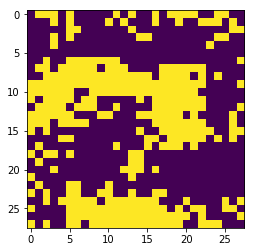

[[7]]


In [18]:
mpe_ivs_val, mpe_latent_val = \
    sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, num_rows*num_cols), dtype=int) * -1,
                                               latent: [[-1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 0

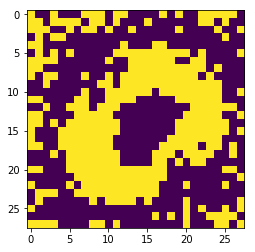

[[0]]


In [19]:
mpe_ivs_val, mpe_latent_val = \
    sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, num_rows*num_cols), dtype=int) * -1,
                                               latent: [[0]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 1

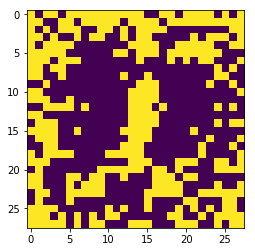

[[1]]


In [20]:
mpe_ivs_val, mpe_latent_val = \
    sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, num_rows*num_cols), dtype=int) * -1,
                                               latent: [[1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 5

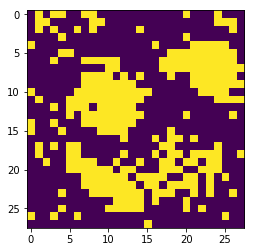

[[5]]


In [21]:
mpe_ivs_val, mpe_latent_val = \
    sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, num_rows*num_cols), dtype=int) * -1,
                                               latent: [[5]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### Classification of Training Data

In [22]:
accuracy_per_step = []
for batch in range(num_batches):
    start = (batch) * batch_size
    if last_batch and (batch + 1) == num_batches:
        stop = train_set.shape[0]
    else:
        stop = (batch + 1) * batch_size
        
    # Session
    mpe_latent_val = sess.run([mpe_latent],
                              feed_dict={ivs: train_set[start:stop],
                                         latent: np.ones((stop - start, 1)) * -1})
    accuracy_per_step.append(np.mean(mpe_latent_val == train_labels[start:stop]))
    
accuracy = np.mean(accuracy_per_step) * 100
print("Classification accyracy on Training set: ", accuracy)


#mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: train_set, 
#                                                   latent: np.ones((train_set.shape[0], 1))*-1})
#result=(mpe_latent_val==train_labels)
#np.sum(result) / train_labels.size

Classification accyracy on Training set:  92.0581818182


### Classification of Test Data

In [23]:
test_set = test_images
test_labels = np.reshape(test_labels, (-1, 1))

In [24]:
num_batches = test_set.shape[0] // batch_size
accuracy_per_step = []
for batch in range(num_batches):
    start = (batch) * batch_size
    if last_batch and (batch + 1) == num_batches:
        stop = test_set.shape[0]
    else:
        stop = (batch + 1) * batch_size
        
    # Session
    mpe_latent_val = sess.run([mpe_latent],
                              feed_dict={ivs: test_set[start:stop],
                                         latent: np.ones((stop - start, 1)) * -1})
    accuracy_per_step.append(np.mean(mpe_latent_val == test_labels[start:stop]))
    
accuracy = np.mean(accuracy_per_step) * 100
print("Classification accyracy on Test set: ", accuracy)

#mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: test_set, 
#                                                   latent: np.ones((test_set.shape[0], 1))*-1})
#result=(mpe_latent_val==test_labels)
#np.sum(result) / test_labels.size

Classification accyracy on Test set:  92.1000481
